### Data Analysis: 

In [1]:
import pandas as pd 
from IPython.display import display
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
import plotly.io as pio

import matplotlib.ticker as mtick 
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, cross_val_predict, cross_val_score,\
    StratifiedKFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score, f1_score, confusion_matrix, precision_recall_curve, precision_score, recall_score, auc
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier



from sklearn.utils import shuffle


import warnings

warnings.filterwarnings('ignore')

In [2]:
try:
    contract= pd.read_csv('contract.csv')
    personal = pd.read_csv('personal.csv')
    internet = pd.read_csv('internet.csv')
    phone = pd.read_csv('phone.csv')
    
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv') 

- Let's merge data

In [3]:
data = personal.merge(contract, on = 'customerID', how = 'right').merge(internet, on = 'customerID', how = 'right').merge(phone, on = 'customerID', how = 'left')


In [6]:
data.head()

customerID  gender  SeniorCitizen Partner Dependents   BeginDate  \
0  7590-VHVEG  Female              0     Yes         No  2020-01-01   
1  5575-GNVDE    Male              0      No         No  2017-04-01   
2  3668-QPYBK    Male              0      No         No  2019-10-01   
3  7795-CFOCW    Male              0      No         No  2016-05-01   
4  9237-HQITU  Female              0      No         No  2019-09-01   

               EndDate            Type PaperlessBilling  \
0                   No  Month-to-month              Yes   
1                   No        One year               No   
2  2019-12-01 00:00:00  Month-to-month              Yes   
3                   No        One year               No   
4  2019-11-01 00:00:00  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges InternetService  \
0           Electronic check           29.85        29.85             DSL   
1               Mailed check           56.95       1889.5             DSL   
2               Mailed check           53.85       108.15             DSL   
3  Bank transfer (automatic)           42.30      1840.75             DSL   
4           Electronic check           70.70       151.65     Fiber optic   

  OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
0             No          Yes               No          No          No   
1            Yes           No              Yes          No          No   
2            Yes          Yes               No          No          No   
3            Yes           No              Yes         Yes          No   
4             No           No               No          No          No   

  StreamingMovies MultipleLines  
0              No           NaN  
1              No            No  
2              No            No  
3              No           NaN  
4              No            No

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5517 entries, 0 to 5516
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5517 non-null   object 
 1   gender            5517 non-null   object 
 2   SeniorCitizen     5517 non-null   int64  
 3   Partner           5517 non-null   object 
 4   Dependents        5517 non-null   object 
 5   BeginDate         5517 non-null   object 
 6   EndDate           5517 non-null   object 
 7   Type              5517 non-null   object 
 8   PaperlessBilling  5517 non-null   object 
 9   PaymentMethod     5517 non-null   object 
 10  MonthlyCharges    5517 non-null   float64
 11  TotalCharges      5517 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [8]:
data.describe().T

count       mean        std    min    25%    50%    75%  \
SeniorCitizen   5517.0   0.197571   0.398203   0.00   0.00   0.00   0.00   
MonthlyCharges  5517.0  76.844254  21.924661  23.45  59.95  79.45  94.45   

                   max  
SeniorCitizen     1.00  
MonthlyCharges  118.75

Convert <code>TotalCharges</code> to a numeric data type.

In [9]:
data.TotalCharges = pd.to_numeric(data.TotalCharges, errors = 'coerce')

##### Missing values :

In [10]:
data.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
BeginDate             0
EndDate               0
Type                  0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
MultipleLines       682
dtype: int64

<code>MultipleLines</code> has 682 missings , let's convert them as "No phone service" and <code>TotalCharges</code> has 5 , remove them.


In [11]:
data.MultipleLines = data.MultipleLines.fillna("No phone service")

In [12]:
data.dropna(inplace = True)

##### Duplicates :

In [13]:
print('Number of duplicates: ', data.duplicated().sum())

Количество дубликатов:  0


In [14]:
print('Number of duplicates in CustomerId: ', data.customerID.duplicated().sum())

Количество дубликатов в столбце CustomerId:  0


### Let's conduct a study and immediately check for anomalous values

#### Gender :

In [15]:
data.gender.value_counts()

Male      2775
Female    2737
Name: gender, dtype: int64

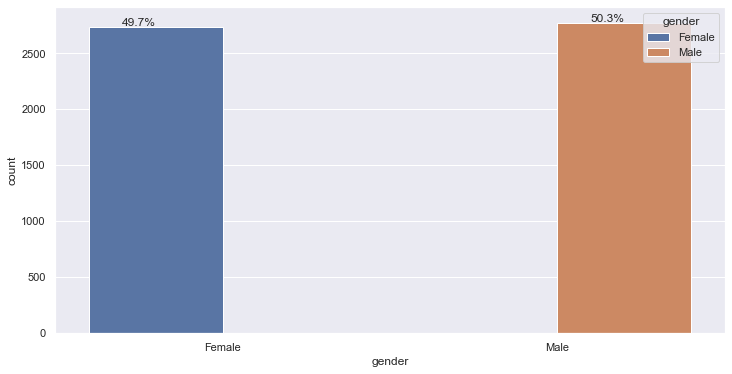

In [16]:
sns.set(rc = {'figure.figsize':(12,6)})

ax = sns.countplot(data = data, x = data.gender, hue = data.gender)

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

About half of the customers in our dataset are male and the other half are female.

#### Senior Sitizen :

In [17]:
data.SeniorCitizen.value_counts()

0    4422
1    1090
Name: SeniorCitizen, dtype: int64

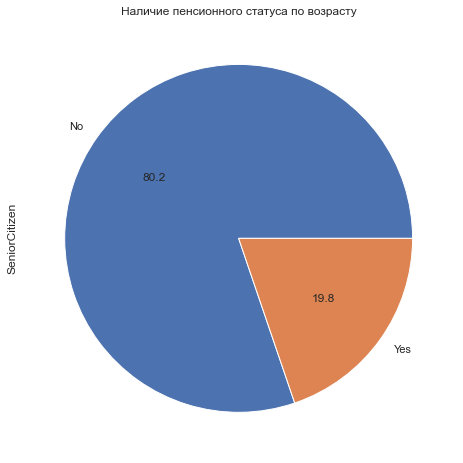

In [18]:
def autopct(pct): 
    return ('%.1f' % pct)
plt.figure(figsize = (6,6))
plt.title("Having a retirement status by age")
(data.SeniorCitizen.value_counts()*100/ len(data)).plot(kind = 'pie', figsize=(8, 8),y = 'SeniorCitizen',
                                                  autopct=autopct, labels=['No', 'Yes']);


Only about 20% of clients are pensioners. Thus, most of our clients in the data are young people.

#### Partner & Dependents :

In [19]:
data.Partner.value_counts()

No     2852
Yes    2660
Name: Partner, dtype: int64

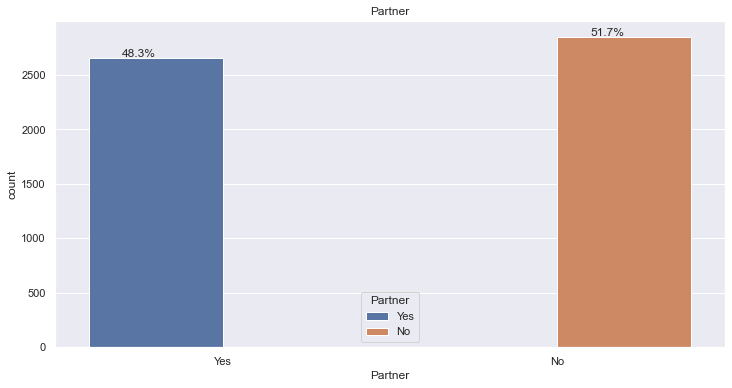

In [20]:
ax = sns.countplot(x = data['Partner'], hue = data['Partner'])
plt.title('Partner')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))


In [21]:
data.Dependents.value_counts()

No     4050
Yes    1462
Name: Dependents, dtype: int64

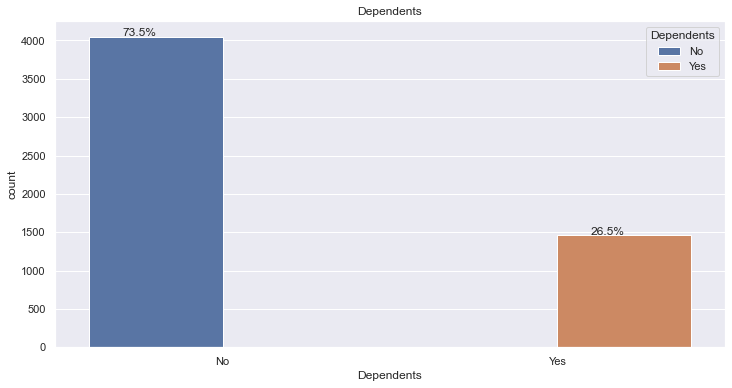

In [22]:
ax = sns.countplot(x = data['Dependents'], hue = data['Dependents'])
plt.title('Dependents')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

About 50% of clients have a partner, and only 26.5% of the total number of clients have dependents.

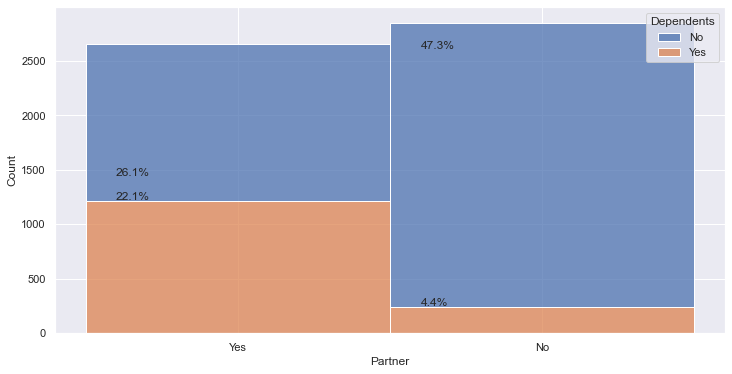

In [23]:
ax = sns.histplot(data = data, x = 'Partner', hue = 'Dependents', multiple="stack")
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

* About 22% of clients have a partner and have dependents.
* 26% - have a partner and do not have dependents.
* 47% of clients who do not have a partner and do not have dependents.
* And only 4.4% who do not have a partner and are not dependent on others.

#### Type : 

In [24]:
data.Type.value_counts()

Month-to-month    3351
One year          1109
Two year          1052
Name: Type, dtype: int64

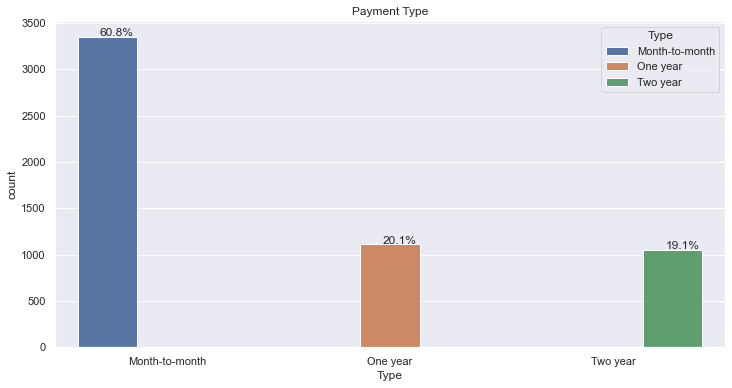

In [25]:
ax = sns.countplot(x = data['Type'], hue = data['Type'])
plt.title('Payment Type')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

As you can see from this graph, most clients enter into monthly contracts. While there is an equal number of clients in 1 year and 2 year contracts.

#### Paper less Billing  :

In [26]:
data.PaperlessBilling.value_counts()

Yes    3723
No     1789
Name: PaperlessBilling, dtype: int64

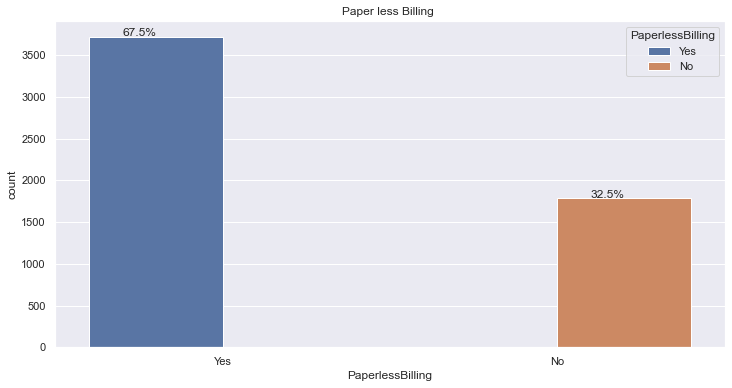

In [27]:
ax = sns.countplot(x = data['PaperlessBilling'], hue = data['PaperlessBilling'])
plt.title('Paper less Billing ')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

Almost 70% of users do not receive paper payments.

#### Payment Method:

In [28]:
data.PaymentMethod.value_counts()

Electronic check             2243
Bank transfer (automatic)    1210
Credit card (automatic)      1190
Mailed check                  869
Name: PaymentMethod, dtype: int64

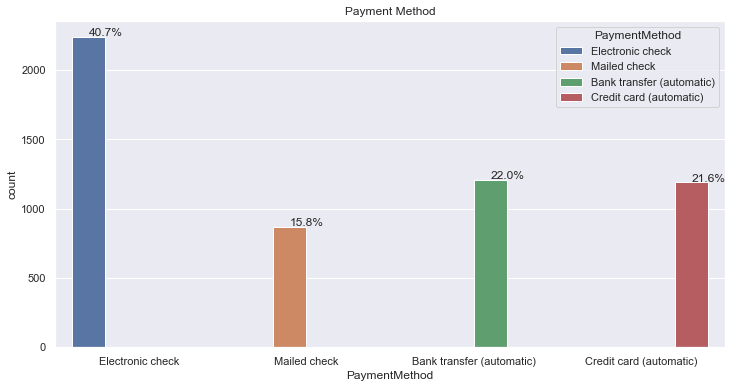

In [29]:
sns.set(rc = {'figure.figsize':(12,6)})

ax = sns.countplot(x = data['PaymentMethod'], hue = data['PaymentMethod'])
plt.title('Payment Method')
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

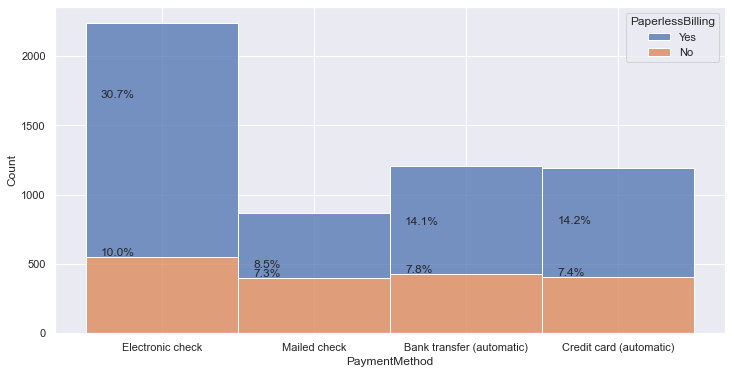

In [30]:
ax = sns.histplot(data = data, x = 'PaymentMethod', hue = 'PaperlessBilling', multiple="stack")
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

#### Services :

In [31]:
data.InternetService.value_counts()

Fiber optic    3096
DSL            2416
Name: InternetService, dtype: int64

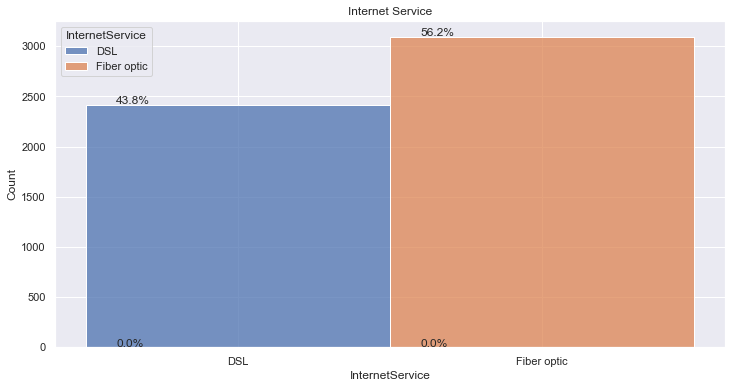

In [32]:
ax = sns.histplot(data = data, x = 'InternetService', hue = 'InternetService', multiple="stack")
plt.title('Internet Service')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

In [33]:
data.OnlineSecurity.value_counts()

No     3497
Yes    2015
Name: OnlineSecurity, dtype: int64

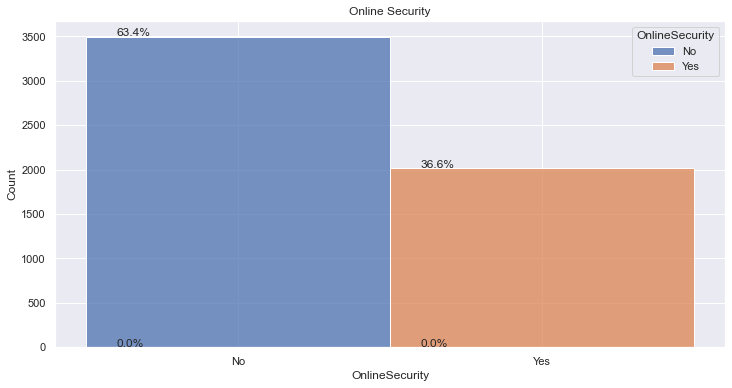

In [34]:
ax = sns.histplot(data = data, x = 'OnlineSecurity', hue = 'OnlineSecurity', multiple="stack")
plt.title('Online Security')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

In [35]:
data.OnlineBackup.value_counts()

No     3087
Yes    2425
Name: OnlineBackup, dtype: int64

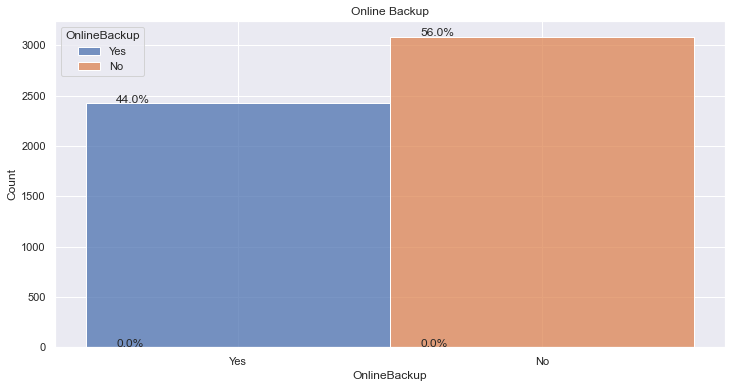

In [36]:
ax = sns.histplot(data = data, x = 'OnlineBackup', hue = 'OnlineBackup', multiple="stack")
plt.title('Online Backup')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

In [37]:
data.DeviceProtection.value_counts()

No     3094
Yes    2418
Name: DeviceProtection, dtype: int64

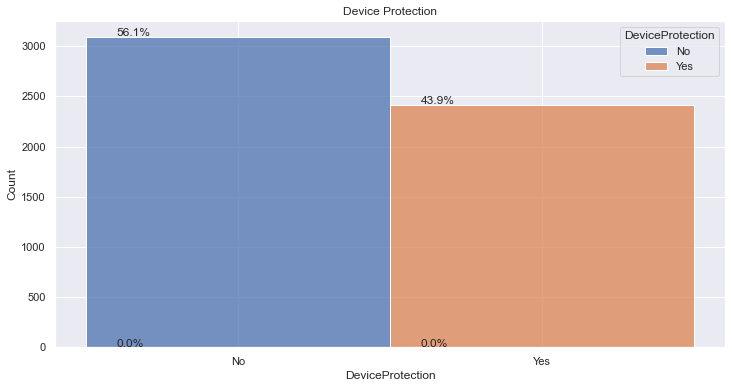

In [38]:
ax = sns.histplot(data = data, x = 'DeviceProtection', hue = 'DeviceProtection', multiple="stack")
plt.title('Device Protection')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

In [39]:
data.TechSupport.value_counts()

No     3472
Yes    2040
Name: TechSupport, dtype: int64

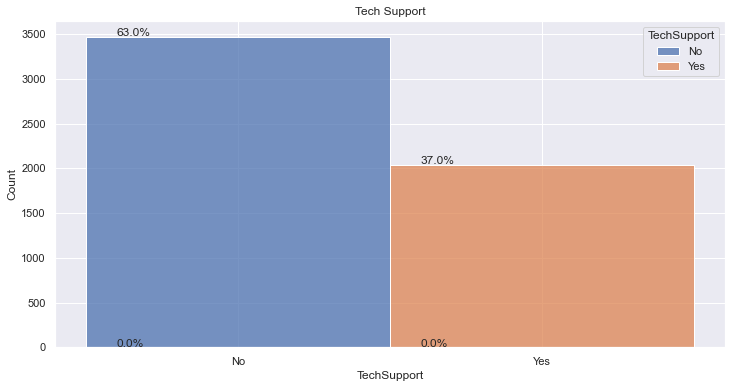

In [40]:
ax = sns.histplot(data = data, x = 'TechSupport', hue = 'TechSupport', multiple="stack")
plt.title('Tech Support')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

In [41]:
data.StreamingTV.value_counts()

No     2809
Yes    2703
Name: StreamingTV, dtype: int64

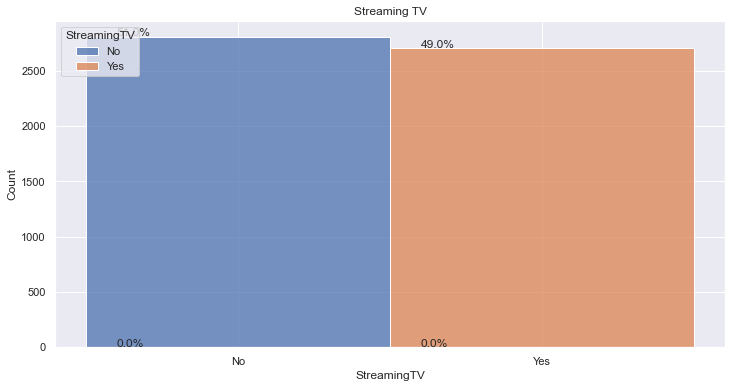

In [42]:
ax = sns.histplot(data = data, x = 'StreamingTV', hue = 'StreamingTV', multiple="stack")
plt.title('Streaming TV')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

In [43]:
data.StreamingMovies.value_counts()

No     2781
Yes    2731
Name: StreamingMovies, dtype: int64

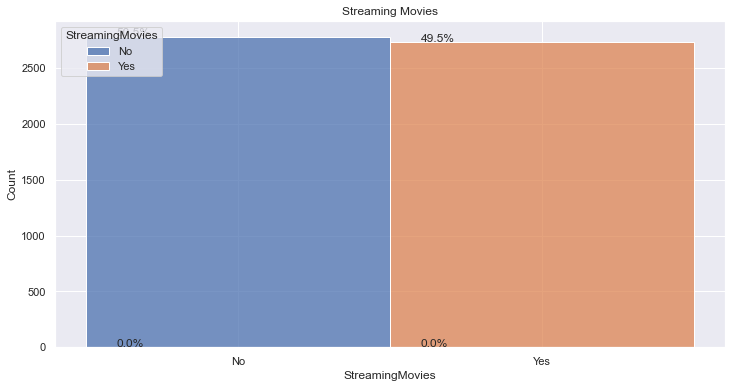

In [44]:
ax = sns.histplot(data = data, x = 'StreamingMovies', hue = 'StreamingMovies', multiple="stack")
plt.title('Streaming Movies')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

In [45]:
data.MultipleLines.value_counts()

Yes                 2627
No                  2205
No phone service     680
Name: MultipleLines, dtype: int64

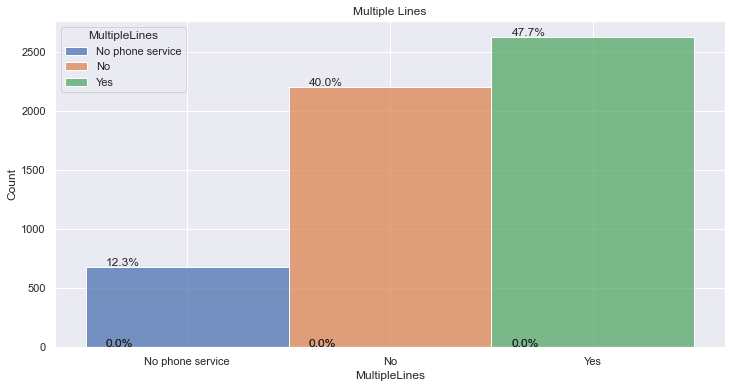

In [46]:
ax = sns.histplot(data = data, x = 'MultipleLines', hue = 'MultipleLines', multiple="stack")
plt.title('Multiple Lines')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

- Let's check <code>MonthlyCharges</code> and <code>TotalCharges</code> for outliers:

In [47]:
fig = make_subplots(rows=1, cols=2, 
                    subplot_titles=['MonthlyCharges', 'TotalCharges'])

fig.add_trace(go.Box(y = data['MonthlyCharges'],
                     marker_color='#800000',
                     name='MonthlyCharges'), 1, 1)

fig.add_trace(go.Box(y = data['TotalCharges'],
                     marker_color='#D2691E',
                     name='TotalCharges'), 1, 2)

There are no emissions.

- Let's take a quick look at the relationship between monthly and total charges.

<AxesSubplot:xlabel='MonthlyCharges', ylabel='TotalCharges'>

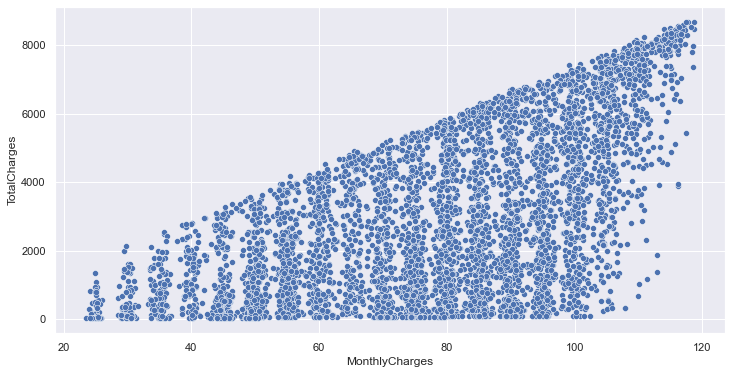

In [48]:
sns.scatterplot(x=data['MonthlyCharges'], y=data['TotalCharges'])

It can be seen that the total costs increase as the monthly bill for the client increases.

- Let's create a column that will say whether the client left or not. He will be the target in the future.

In [49]:
def churn_func(data):
    churn = data.EndDate
    if 'No' in churn :
        return 0 #the client didn't leave
    else:
        return 1 #the client leave
data['churn'] = data.apply(churn_func, axis = 1)    
    

In [50]:
data.head()

customerID  gender  SeniorCitizen Partner Dependents   BeginDate  \
0  7590-VHVEG  Female              0     Yes         No  2020-01-01   
1  5575-GNVDE    Male              0      No         No  2017-04-01   
2  3668-QPYBK    Male              0      No         No  2019-10-01   
3  7795-CFOCW    Male              0      No         No  2016-05-01   
4  9237-HQITU  Female              0      No         No  2019-09-01   

               EndDate            Type PaperlessBilling  \
0                   No  Month-to-month              Yes   
1                   No        One year               No   
2  2019-12-01 00:00:00  Month-to-month              Yes   
3                   No        One year               No   
4  2019-11-01 00:00:00  Month-to-month              Yes   

               PaymentMethod  ...  TotalCharges  InternetService  \
0           Electronic check  ...         29.85              DSL   
1               Mailed check  ...       1889.50              DSL   
2               Mailed check  ...        108.15              DSL   
3  Bank transfer (automatic)  ...       1840.75              DSL   
4           Electronic check  ...        151.65      Fiber optic   

  OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
0             No          Yes               No          No          No   
1            Yes           No              Yes          No          No   
2            Yes          Yes               No          No          No   
3            Yes           No              Yes         Yes          No   
4             No           No               No          No          No   

  StreamingMovies     MultipleLines churn  
0              No  No phone service     0  
1              No                No     0  
2              No                No     1  
3              No  No phone service     0  
4              No                No     1  

[5 rows x 21 columns]

- Let's create a column in which the number of months during which the client remained in the company. For those customers who have not left, we will indicate the current date February 1, 2020.

In [51]:
data['EndDate'] = data['EndDate'].replace('No', '2020-02-01')

In [52]:
data['BeginDate'] = pd.to_datetime(data['BeginDate'], format='%Y-%m-%d')
data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y-%m-%d')

In [53]:
data['tenure'] = data['EndDate'] - data['BeginDate']
data['tenure'] = data['tenure'].astype('timedelta64[D]').astype('int')
data['tenure'].head()

0      31
1    1036
2      61
3    1371
4      61
Name: tenure, dtype: int64

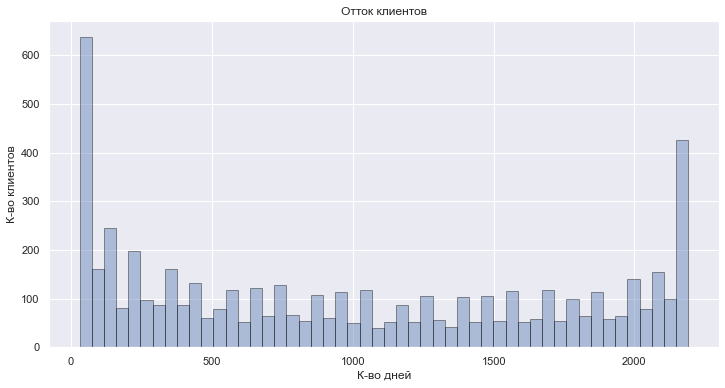

In [55]:
ax = sns.distplot(data['tenure'], hist = True, kde = False , bins= 50,
                 kde_kws={'linewidth': 4},
                 hist_kws={'edgecolor':'black'})
ax.set_title('Customer churn')
ax.set_ylabel('Number of clients')
ax.set_xlabel('Number of days');


We see that many clients work with a telecommunications company for only a month, while many work for about 72 months. This could potentially be due to different clients having different contracts. Thus, on the basis of the concluded contract, it may be more / less easier for customers to stay / leave the telecommunications company.

- Let's look at the tenure of a client depending on the type of their contract.

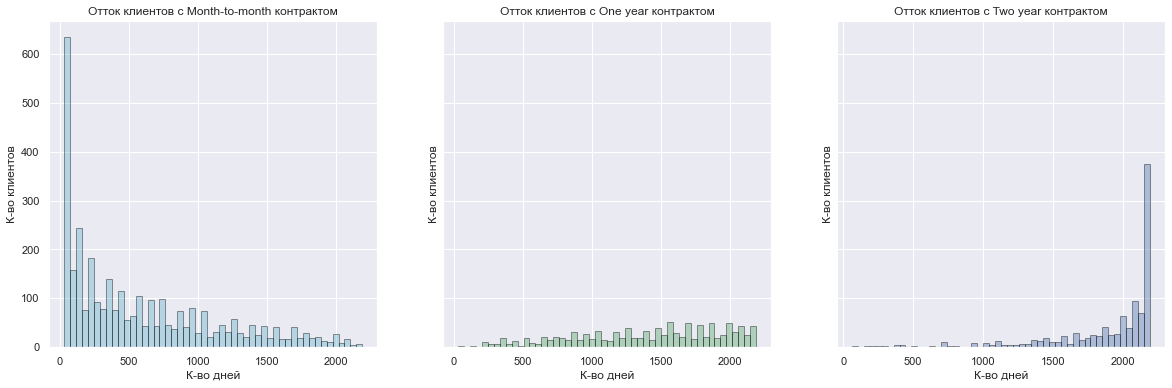

In [56]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey = True, figsize = (20,6))

ax = sns.distplot(data[data['Type'] == 'Month-to-month']['tenure'], hist = True, kde = False , bins= 50,
                 kde_kws={'linewidth': 4},
                 hist_kws={'edgecolor':'black'},
                 color = 'c', ax = ax1)
ax.set_title('Customer churn with Month-to-month contract')
ax.set_ylabel('Number of clients')
ax.set_xlabel('Number of days')


ax = sns.distplot(data[data['Type'] == 'One year']['tenure'], hist = True, kde = False , bins= 50,
                 kde_kws={'linewidth': 4},
                 hist_kws={'edgecolor':'black'},
                 color = 'g', ax = ax2)
ax.set_title('Client churn with One year contract')
ax.set_ylabel('Number of clients')
ax.set_xlabel('Number of days')


ax = sns.distplot(data[data['Type'] == 'Two year']['tenure'], hist = True, kde = False , bins= 50,
                 kde_kws={'linewidth': 4},
                 hist_kws={'edgecolor':'black'},
                 color = 'b', ax = ax3)
ax.set_title('Client churn with Two year contract')
ax.set_ylabel('Number of clients')
ax.set_xlabel('Number of days');

Interestingly, most monthly contracts last 1-2 months, while two-year contracts tend to last around 70 months. This shows that customers with a longer contract are more loyal to the company and tend to stay with it for a longer period of time.

- Let's look at the churn rate in our data.

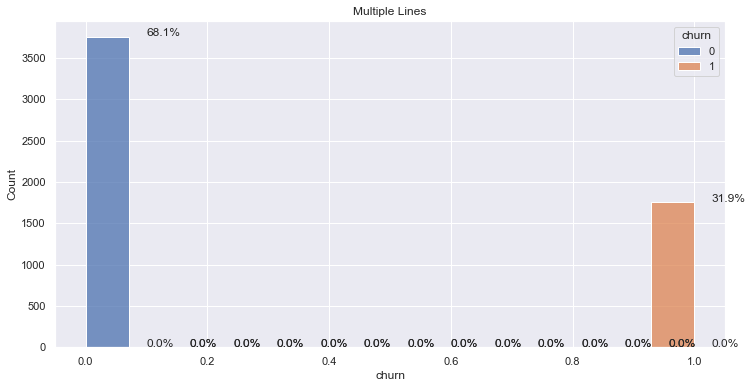

In [57]:
ax = sns.histplot(data = data, x = 'churn', hue = 'churn', multiple="stack")
plt.title('Multiple Lines')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))


About 32% left.

- Let's look at the churn of customers depending on the type of their contract.

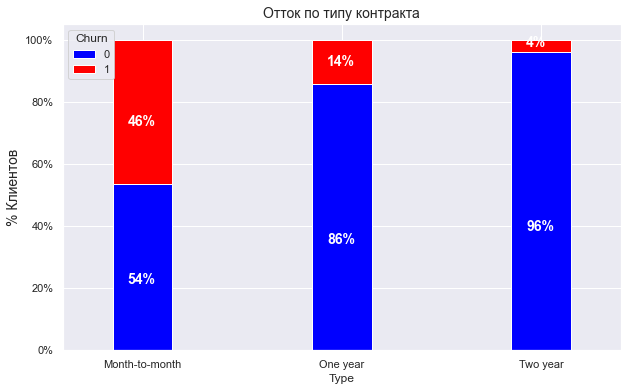

In [58]:
contract_churn = data.groupby(['Type','churn']).size().unstack()

ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (10,6),
                                                                color = ['blue', 'red'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(title = 'Churn')
ax.set_ylabel('% of clients',size = 14)
ax.set_title('Churn by contract type',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

Clients who have a monthly contract have a very high churn rate.

- Monthly payment outflow

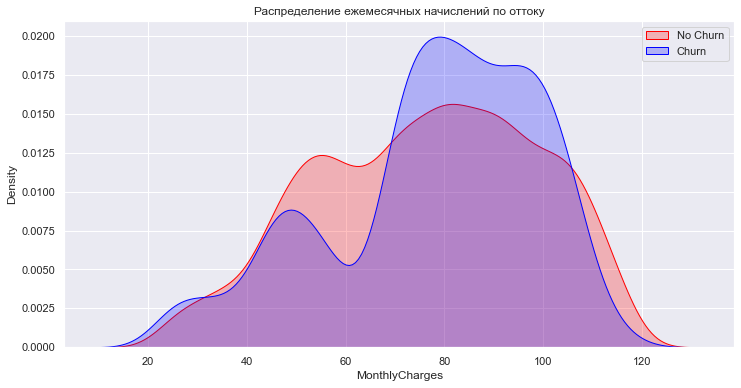

In [59]:
ax = sns.kdeplot(data[data['churn'] == 0]['MonthlyCharges'], color = 'Red', shade = True)
ax = sns.kdeplot(data[data['churn'] == 1]['MonthlyCharges'], color = 'Blue', shade = True, ax=ax)
ax.legend(['No Churn', 'Churn'])
ax.set_title('The distribution of monthly charges by outflow');

Higher churn rates when monthly payments are high.

- Churn on total expenses

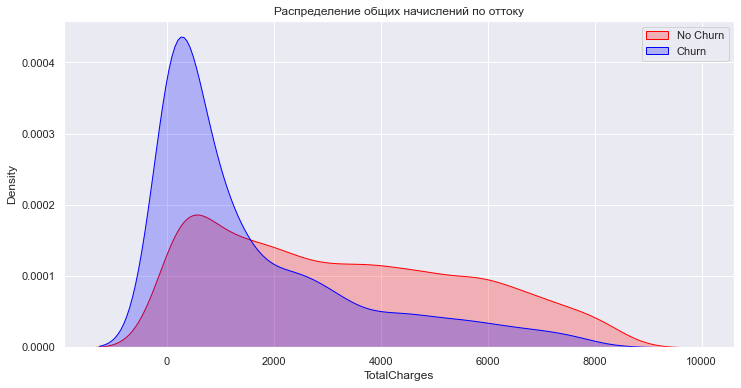

In [60]:
ax = sns.kdeplot(data[data['churn'] == 0]['TotalCharges'], color = 'Red', shade = True)
ax = sns.kdeplot(data[data['churn'] == 1]['TotalCharges'], color = 'Blue', shade = True, ax=ax)
ax.legend(['No Churn', 'Churn'])
ax.set_title('Distribution of total charges on outflow');

Higher churn rates when total payments are low.

In [61]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'MultipleLines', 'churn', 'tenure'],
      dtype='object')

### Removing features

In [62]:
data = data.drop(['BeginDate', 'EndDate', 'customerID'], axis = 1)
data.head()

gender  SeniorCitizen Partner Dependents            Type PaperlessBilling  \
0  Female              0     Yes         No  Month-to-month              Yes   
1    Male              0      No         No        One year               No   
2    Male              0      No         No  Month-to-month              Yes   
3    Male              0      No         No        One year               No   
4  Female              0      No         No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  TotalCharges InternetService  \
0           Electronic check           29.85         29.85             DSL   
1               Mailed check           56.95       1889.50             DSL   
2               Mailed check           53.85        108.15             DSL   
3  Bank transfer (automatic)           42.30       1840.75             DSL   
4           Electronic check           70.70        151.65     Fiber optic   

  OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
0             No          Yes               No          No          No   
1            Yes           No              Yes          No          No   
2            Yes          Yes               No          No          No   
3            Yes           No              Yes         Yes          No   
4             No           No               No          No          No   

  StreamingMovies     MultipleLines  churn  tenure  
0              No  No phone service      0      31  
1              No                No      0    1036  
2              No                No      1      61  
3              No  No phone service      0    1371  
4              No                No      1      61

### Converting categorical features

In [63]:
data_ohe = pd.get_dummies(data, drop_first=True) 
data_ohe.head()

SeniorCitizen  MonthlyCharges  TotalCharges  churn  tenure  gender_Male  \
0              0           29.85         29.85      0      31            0   
1              0           56.95       1889.50      0    1036            1   
2              0           53.85        108.15      1      61            1   
3              0           42.30       1840.75      0    1371            1   
4              0           70.70        151.65      1      61            0   

   Partner_Yes  Dependents_Yes  Type_One year  Type_Two year  ...  \
0            1               0              0              0  ...   
1            0               0              1              0  ...   
2            0               0              0              0  ...   
3            0               0              1              0  ...   
4            0               0              0              0  ...   

   PaymentMethod_Mailed check  InternetService_Fiber optic  \
0                           0                            0   
1                           1                            0   
2                           1                            0   
3                           0                            0   
4                           0                            1   

   OnlineSecurity_Yes  OnlineBackup_Yes  DeviceProtection_Yes  \
0                   0                 1                     0   
1                   1                 0                     1   
2                   1                 1                     0   
3                   1                 0                     1   
4                   0                 0                     0   

   TechSupport_Yes  StreamingTV_Yes  StreamingMovies_Yes  \
0                0                0                    0   
1                0                0                    0   
2                0                0                    0   
3                1                0                    0   
4                0                0                    0   

   MultipleLines_No phone service  MultipleLines_Yes  
0                               1                  0  
1                               0                  0  
2                               0                  0  
3                               1                  0  
4                               0                  0  

[5 rows x 23 columns]

- Let's see how customer churn correlates with other signs

<AxesSubplot:>

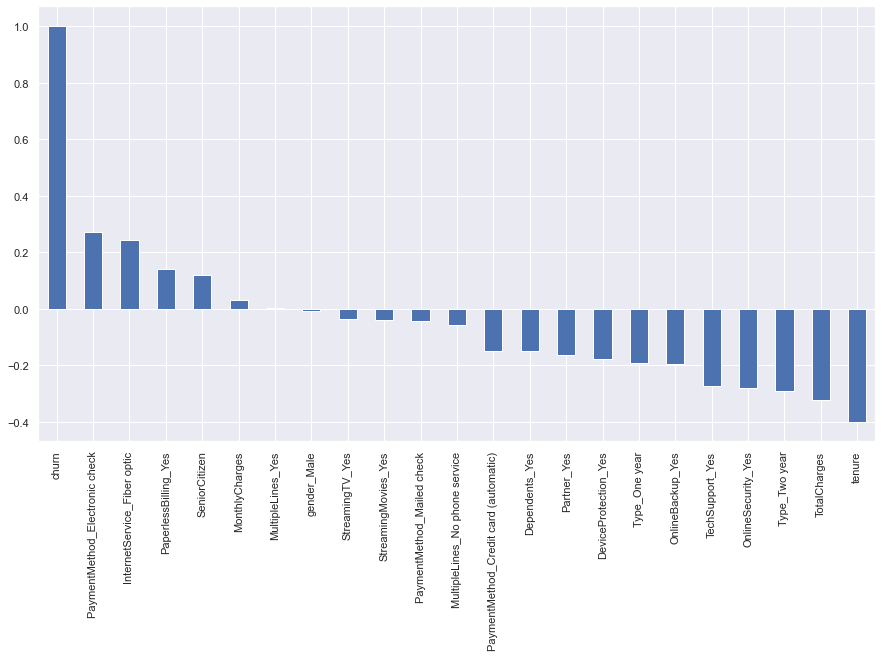

In [64]:
plt.figure(figsize=(15,8))
data_ohe.corr()['churn'].sort_values(ascending = False).plot(kind = 'bar');


Payment Method by electronic check, paper less billing and senior citizen are positively correlated with churn. While tenure, total spending and two year contract are negatively correlated with churn.

### Let's divide the data into samples:

In [65]:
features = data_ohe.drop('churn', axis = 1)
target = data_ohe['churn']



- Let's do feature scaling

In [66]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.3, random_state=12345)



In [67]:
features_train.shape

(3858, 22)

In [68]:
features_test.shape

(1654, 22)

In [69]:
features_train.head()

SeniorCitizen  MonthlyCharges  TotalCharges  tenure  gender_Male  \
2065              0           70.70        140.70      61            1   
3774              1           33.45       1500.25    1310            0   
3968              0           40.60       1494.50    1187            1   
1931              1           99.95       3186.65     944            0   
5390              0           43.95         43.95      30            0   

      Partner_Yes  Dependents_Yes  Type_One year  Type_Two year  \
2065            0               0              0              0   
3774            0               0              0              0   
3968            0               0              0              0   
1931            0               0              0              0   
5390            0               0              0              0   

      PaperlessBilling_Yes  ...  PaymentMethod_Mailed check  \
2065                     0  ...                           0   
3774                     1  ...                           0   
3968                     1  ...                           0   
1931                     1  ...                           0   
5390                     0  ...                           1   

      InternetService_Fiber optic  OnlineSecurity_Yes  OnlineBackup_Yes  \
2065                            1                   0                 0   
3774                            0                   1                 1   
3968                            0                   0                 0   
1931                            1                   0                 1   
5390                            0                   0                 0   

      DeviceProtection_Yes  TechSupport_Yes  StreamingTV_Yes  \
2065                     0                0                0   
3774                     0                0                0   
3968                     0                1                0   
1931                     0                0                1   
5390                     0                0                0   

      StreamingMovies_Yes  MultipleLines_No phone service  MultipleLines_Yes  
2065                    0                               0                  0  
3774                    0                               1                  0  
3968                    1                               1                  0  
1931                    1                               0                  1  
5390                    0                               0                  0  

[5 rows x 22 columns]

In [70]:
target_train.head()

2065    1
3774    0
3968    0
1931    1
5390    1
Name: churn, dtype: int64

## Let's train models
To solve the classification problem, consider the following studied models:
* DTC decision tree
* RFC random forest
* LRC logistic regression
* k-nearest neighbor method kNN
* LGBM Boost
* Cat Boost

### Decision Tree 

- Using <code>RandomSearchCV</code> and <code>GridSearchCV</code> we will select the best hyperparameters. We will evaluate the quality of the model using the metric F1

In [71]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [72]:
%%time
dtc_model = DecisionTreeClassifier(random_state = 12345)

dtc_randomized_param = {
    'max_depth': range(1,250),
    'min_samples_leaf': range(1,250),
    'criterion': ['entropy', 'gini'] 
}

dtc_randomized_search = RandomizedSearchCV(dtc_model, dtc_randomized_param, n_iter=100, cv=5, n_jobs=-1,
                               scoring='f1', return_train_score=True, random_state=12345)

dtc_randomized_search.fit(features_train, target_train)

CPU times: user 539 ms, sys: 168 ms, total: 707 ms
Wall time: 2.74 s


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=12345),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': range(1, 250),
                                        'min_samples_leaf': range(1, 250)},
                   random_state=12345, return_train_score=True, scoring='f1')

In [73]:
print('Best F1 score: {}'
      .format(dtc_randomized_search.best_score_))
print('Best parameters: {}'
      .format(dtc_randomized_search.best_params_))

Наивысшее значение F1: 0.6101124309394519
Гиперпараметры для наилучшей модели: {'min_samples_leaf': 15, 'max_depth': 174, 'criterion': 'entropy'}


We have obtained hyperparameters, but their estimate is rather rough. That is, we know the invalid value of the hyperparameter, the interval in which this value will cover.

Now we will perform a more accurate search for the values of hyperparameters

In [74]:
%%time
dtc_param_grid = {
    'max_depth': range(160,190), 
    'min_samples_leaf': range(5,25),
    'criterion': ['entropy']
}

dtc_grid_search = GridSearchCV(dtc_model, dtc_param_grid, cv=5, n_jobs=-1,
                               scoring='f1', return_train_score=True)

dtc_grid_search.fit(features_train, target_train)

CPU times: user 1.82 s, sys: 146 ms, total: 1.97 s
Wall time: 8.13 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=12345),
             n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': range(160, 190),
                         'min_samples_leaf': range(5, 25)},
             return_train_score=True, scoring='f1')

In [75]:
print('Best F1 score: {}'
      .format(dtc_grid_search.best_score_))
print('Best parameters: {}'
      .format(dtc_grid_search.best_params_))

Наивысшее значение F1: 0.6141046377583717
Гиперпараметры для наилучшей модели: {'criterion': 'entropy', 'max_depth': 160, 'min_samples_leaf': 7}


Let's calculate the remaining metrics for this model. First, let's write a function that would take a classifier and data as input, and return a dataframe with metrics

In [76]:
def result_metrics(estimator, x, y, column_name):
    
    cv_results = cross_validate(estimator, x, y, cv=6,
                                scoring=('accuracy', 'precision', 'recall', 'f1'),
                                return_train_score=True)
    roc_auc_cv = cross_val_score(estimator, x, y, cv=6, scoring='roc_auc')

    cv_metrics_dict = {'Accuracy': cv_results['test_accuracy'].mean(),
                       'Precision': cv_results['test_precision'].mean(),
                       'Recall': cv_results['test_recall'].mean(),
                       'F1': cv_results['test_f1'].mean(),
                       'AUC-ROC': roc_auc_cv.mean()
                      }
    return pd.DataFrame.from_dict(cv_metrics_dict, orient='index', columns=[column_name])

In [77]:
best_dtc = DecisionTreeClassifier(random_state=12345,
                                  max_depth=160,
                                  min_samples_leaf=7,
                                  criterion='entropy')
                                  

dtc_metrics = result_metrics(best_dtc, features_train, target_train, 'DTC')
dtc_metrics

DTC
Accuracy   0.747019
Precision  0.616037
Recall     0.574353
F1         0.594124
AUC-ROC    0.776390

### Random Forest

- Using <code>RandomSearchCV</code> and <code>GridSearchCV</code> we will select the best hyperparameters. We will evaluate the quality of the model using the metric F1

In [78]:
%%time
rfc_model = RandomForestClassifier(random_state = 12345)

rfc_randomized_param = {'max_depth': range(1,200),
                       'n_estimators' : range(1,200)}
rfc_randomized_search = RandomizedSearchCV(rfc_model, rfc_randomized_param, n_iter = 100, 
                                          cv = 6 , n_jobs = -1, scoring = 'f1',
                                           return_train_score=True, random_state=12345)
rfc_randomized_search.fit(features_train, target_train)

CPU times: user 1.63 s, sys: 156 ms, total: 1.78 s
Wall time: 34.4 s


RandomizedSearchCV(cv=6, estimator=RandomForestClassifier(random_state=12345),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': range(1, 200),
                                        'n_estimators': range(1, 200)},
                   random_state=12345, return_train_score=True, scoring='f1')

In [79]:
print('Best F1 score: {}'
      .format(rfc_randomized_search.best_score_))
print('Best parameters: {}'
      .format(rfc_randomized_search.best_params_))

Наивысшее значение F1: 0.6217591101597076
Гиперпараметры для наилучшей модели: {'n_estimators': 91, 'max_depth': 9}


In [80]:
%%time
rfc_param_grid = {
    'n_estimators': range(85,110),
    'max_depth': range(1,25)
}

rfc_grid_search = GridSearchCV(rfc_model, rfc_param_grid, cv=6, n_jobs=-1,
                               scoring='f1', return_train_score=True)
rfc_grid_search.fit(features_train, target_train)

CPU times: user 7.54 s, sys: 816 ms, total: 8.36 s
Wall time: 2min 56s


GridSearchCV(cv=6, estimator=RandomForestClassifier(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 25),
                         'n_estimators': range(85, 110)},
             return_train_score=True, scoring='f1')

In [81]:
print('Best F1 score: {}'
      .format(rfc_grid_search.best_score_))
print('Best parameters: {}'
      .format(rfc_grid_search.best_params_))

Наивысшее значение F1: 0.6249843810471396
Гиперпараметры для наилучшей модели: {'max_depth': 10, 'n_estimators': 107}


In [82]:
best_rfc = RandomForestClassifier(random_state=12345,
                                  max_depth=10,
                                  n_estimators=107)

rfc_metrics = result_metrics(best_rfc, features_train, target_train, 'RFC')
rfc_metrics

RFC
Accuracy   0.786677
Precision  0.724629
Recall     0.551805
F1         0.624984
AUC-ROC    0.833125

### Logistic Regression

In [83]:
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

- Let's scale

In [84]:
column = features_train.columns
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(features_train)

features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

features_train.columns = column
features_train.head()

SeniorCitizen  MonthlyCharges  TotalCharges  tenure  gender_Male  \
2065              0           70.70        140.70      61            1   
3774              1           33.45       1500.25    1310            0   
3968              0           40.60       1494.50    1187            1   
1931              1           99.95       3186.65     944            0   
5390              0           43.95         43.95      30            0   

      Partner_Yes  Dependents_Yes  Type_One year  Type_Two year  \
2065            0               0              0              0   
3774            0               0              0              0   
3968            0               0              0              0   
1931            0               0              0              0   
5390            0               0              0              0   

      PaperlessBilling_Yes  ...  PaymentMethod_Mailed check  \
2065                     0  ...                           0   
3774                     1  ...                           0   
3968                     1  ...                           0   
1931                     1  ...                           0   
5390                     0  ...                           1   

      InternetService_Fiber optic  OnlineSecurity_Yes  OnlineBackup_Yes  \
2065                            1                   0                 0   
3774                            0                   1                 1   
3968                            0                   0                 0   
1931                            1                   0                 1   
5390                            0                   0                 0   

      DeviceProtection_Yes  TechSupport_Yes  StreamingTV_Yes  \
2065                     0                0                0   
3774                     0                0                0   
3968                     0                1                0   
1931                     0                0                1   
5390                     0                0                0   

      StreamingMovies_Yes  MultipleLines_No phone service  MultipleLines_Yes  
2065                    0                               0                  0  
3774                    0                               1                  0  
3968                    1                               1                  0  
1931                    1                               0                  1  
5390                    0                               0                  0  

[5 rows x 22 columns]

In [85]:
%%time
logist_model = LogisticRegression(random_state = 12345, solver='liblinear')


logist_param = {'C':  range(-5,5),
                'max_iter' : [10,50,100],
               'fit_intercept': [True, False],
               'warm_start': [True, False],
               'dual': [True, False]}
logist_grid = GridSearchCV(logist_model ,logist_param, n_jobs = -1, cv = 5, verbose = 0,
                          scoring = 'f1', return_train_score=True)
logist_grid.fit(features_train_scaled, target_train)

CPU times: user 414 ms, sys: 79.5 ms, total: 493 ms
Wall time: 1.49 s


GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=12345,
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': range(-5, 5), 'dual': [True, False],
                         'fit_intercept': [True, False],
                         'max_iter': [10, 50, 100],
                         'warm_start': [True, False]},
             return_train_score=True, scoring='f1')

In [86]:
print('Best F1 score: {}'
      .format(logist_grid.best_score_))
print('Best parameters: {}'
      .format(logist_grid.best_params_))

Наивысшее значение F1: 0.6194902980250083
Гиперпараметры для наилучшей модели: {'C': 3, 'dual': True, 'fit_intercept': False, 'max_iter': 10, 'warm_start': True}


In [87]:
best_logistic = LogisticRegression(random_state=12345,
                                  solver='liblinear',
                                  C = 3, dual = True, 
                                 fit_intercept = False, 
                                 max_iter = 10, warm_start = True)
                                  

lrc_metrics = result_metrics(best_logistic, features_train_scaled, target_train, 'LRC')
lrc_metrics

LRC
Accuracy   0.762830
Precision  0.650417
Recall     0.579126
F1         0.611711
AUC-ROC    0.818643

### k-nearest neighbor method

For this method, we will select the number of neighbors k

In [88]:
KNeighborsClassifier().get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [89]:
knn_model = KNeighborsClassifier()

knn_param_grid = {
    'n_neighbors': range(1,10)
}
knn_grid_search = GridSearchCV(knn_model, knn_param_grid, n_jobs = -1, cv = 6, 
                              scoring = 'f1', return_train_score=True)
knn_grid_search.fit(features_train_scaled, target_train)

GridSearchCV(cv=6, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 10)}, return_train_score=True,
             scoring='f1')

In [90]:
print('Best F1 score: {}'
      .format(knn_grid_search.best_score_))
print('Best parameters: {}'
      .format(knn_grid_search.best_params_))

Наивысшее значение F1: 0.5826384211973402
Гиперпараметры для наилучшей модели: {'n_neighbors': 9}


In [91]:
best_knn = KNeighborsClassifier(n_neighbors = 9)

knn_metrics = result_metrics(best_knn, features_train_scaled, target_train, 'kNN')
knn_metrics

kNN
Accuracy   0.731467
Precision  0.585721
Recall     0.580689
F1         0.582638
AUC-ROC    0.774751

### CatBoost

In [92]:
cat_model = CatBoostClassifier()

cat_params = {'depth': range(1,10),
             'iterations' : [1,10,25,50,100,200],
             'learning_rate' : [0.01, 0.05, 0.1]}
cat_grid = GridSearchCV(cat_model, cat_params , n_jobs= -1, scoring = 'f1')
cat_grid.fit(features_train_scaled, target_train)

0:	learn: 0.6489020	total: 59.9ms	remaining: 11.9s
1:	learn: 0.6137753	total: 61.6ms	remaining: 6.09s
2:	learn: 0.5873880	total: 62.8ms	remaining: 4.13s
3:	learn: 0.5627102	total: 64ms	remaining: 3.14s
4:	learn: 0.5457440	total: 65.5ms	remaining: 2.56s
5:	learn: 0.5336532	total: 67ms	remaining: 2.17s
6:	learn: 0.5170956	total: 68.2ms	remaining: 1.88s
7:	learn: 0.5072425	total: 69.7ms	remaining: 1.67s
8:	learn: 0.4985981	total: 71.1ms	remaining: 1.51s
9:	learn: 0.4882646	total: 72.5ms	remaining: 1.38s
10:	learn: 0.4823014	total: 73.5ms	remaining: 1.26s
11:	learn: 0.4758970	total: 74.9ms	remaining: 1.17s
12:	learn: 0.4704555	total: 76.9ms	remaining: 1.11s
13:	learn: 0.4669727	total: 78.1ms	remaining: 1.04s
14:	learn: 0.4611971	total: 79.4ms	remaining: 979ms
15:	learn: 0.4590400	total: 80.6ms	remaining: 927ms
16:	learn: 0.4559914	total: 81.9ms	remaining: 882ms
17:	learn: 0.4532891	total: 82.9ms	remaining: 838ms
18:	learn: 0.4499074	total: 84.1ms	remaining: 801ms
19:	learn: 0.4467653	total

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7f99500db820>,
             n_jobs=-1,
             param_grid={'depth': range(1, 10),
                         'iterations': [1, 10, 25, 50, 100, 200],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='f1')

In [93]:
print('Best F1 score: {}'
      .format(cat_grid.best_score_))
print('Best parameters: {}'
      .format(cat_grid.best_params_))

Наивысшее значение F1: 0.6817970346008246
Гиперпараметры для наилучшей модели: {'depth': 5, 'iterations': 200, 'learning_rate': 0.1}


In [94]:
best_cat = CatBoostClassifier(depth = 5,
                             iterations = 200, learning_rate = 0.1)

cat_metrics = result_metrics(best_cat, features_train_scaled, target_train, 'Cat Boost')
cat_metrics

0:	learn: 0.6472943	total: 1.51ms	remaining: 301ms
1:	learn: 0.6126192	total: 2.57ms	remaining: 254ms
2:	learn: 0.5858359	total: 3.49ms	remaining: 229ms
3:	learn: 0.5640195	total: 4.32ms	remaining: 212ms
4:	learn: 0.5451079	total: 5.23ms	remaining: 204ms
5:	learn: 0.5305336	total: 6.36ms	remaining: 206ms
6:	learn: 0.5193389	total: 7.22ms	remaining: 199ms
7:	learn: 0.5047694	total: 8.1ms	remaining: 194ms
8:	learn: 0.4957372	total: 8.98ms	remaining: 191ms
9:	learn: 0.4896279	total: 10.2ms	remaining: 194ms
10:	learn: 0.4828691	total: 11.6ms	remaining: 199ms
11:	learn: 0.4773342	total: 12.7ms	remaining: 199ms
12:	learn: 0.4724060	total: 13.9ms	remaining: 200ms
13:	learn: 0.4679032	total: 15.2ms	remaining: 202ms
14:	learn: 0.4650099	total: 16.3ms	remaining: 201ms
15:	learn: 0.4602252	total: 17.2ms	remaining: 198ms
16:	learn: 0.4583252	total: 18.4ms	remaining: 198ms
17:	learn: 0.4559861	total: 19.5ms	remaining: 197ms
18:	learn: 0.4520345	total: 20.7ms	remaining: 197ms
19:	learn: 0.4489471	to

161:	learn: 0.3247379	total: 194ms	remaining: 45.5ms
162:	learn: 0.3239127	total: 196ms	remaining: 44.4ms
163:	learn: 0.3235876	total: 197ms	remaining: 43.2ms
164:	learn: 0.3230490	total: 198ms	remaining: 42ms
165:	learn: 0.3224553	total: 199ms	remaining: 40.8ms
166:	learn: 0.3220043	total: 200ms	remaining: 39.6ms
167:	learn: 0.3213521	total: 202ms	remaining: 38.4ms
168:	learn: 0.3195024	total: 203ms	remaining: 37.2ms
169:	learn: 0.3191259	total: 204ms	remaining: 36ms
170:	learn: 0.3186338	total: 205ms	remaining: 34.8ms
171:	learn: 0.3180453	total: 207ms	remaining: 33.6ms
172:	learn: 0.3172959	total: 208ms	remaining: 32.4ms
173:	learn: 0.3170990	total: 209ms	remaining: 31.2ms
174:	learn: 0.3165955	total: 210ms	remaining: 30ms
175:	learn: 0.3162404	total: 211ms	remaining: 28.8ms
176:	learn: 0.3157996	total: 212ms	remaining: 27.6ms
177:	learn: 0.3154360	total: 214ms	remaining: 26.4ms
178:	learn: 0.3151824	total: 215ms	remaining: 25.2ms
179:	learn: 0.3147727	total: 216ms	remaining: 24ms
1

163:	learn: 0.3286791	total: 195ms	remaining: 42.8ms
164:	learn: 0.3280781	total: 196ms	remaining: 41.6ms
165:	learn: 0.3273284	total: 197ms	remaining: 40.4ms
166:	learn: 0.3267971	total: 198ms	remaining: 39.2ms
167:	learn: 0.3262237	total: 200ms	remaining: 38ms
168:	learn: 0.3258395	total: 201ms	remaining: 36.8ms
169:	learn: 0.3251307	total: 202ms	remaining: 35.6ms
170:	learn: 0.3242384	total: 203ms	remaining: 34.4ms
171:	learn: 0.3235416	total: 204ms	remaining: 33.2ms
172:	learn: 0.3232348	total: 205ms	remaining: 32ms
173:	learn: 0.3221615	total: 206ms	remaining: 30.8ms
174:	learn: 0.3215045	total: 208ms	remaining: 29.7ms
175:	learn: 0.3204106	total: 209ms	remaining: 28.5ms
176:	learn: 0.3199320	total: 210ms	remaining: 27.3ms
177:	learn: 0.3185058	total: 211ms	remaining: 26.1ms
178:	learn: 0.3179237	total: 212ms	remaining: 24.9ms
179:	learn: 0.3175589	total: 214ms	remaining: 23.7ms
180:	learn: 0.3172106	total: 215ms	remaining: 22.6ms
181:	learn: 0.3167561	total: 216ms	remaining: 21.4

159:	learn: 0.3159919	total: 193ms	remaining: 48.2ms
160:	learn: 0.3152636	total: 194ms	remaining: 47ms
161:	learn: 0.3144283	total: 196ms	remaining: 45.9ms
162:	learn: 0.3131105	total: 197ms	remaining: 44.7ms
163:	learn: 0.3125190	total: 198ms	remaining: 43.5ms
164:	learn: 0.3116342	total: 199ms	remaining: 42.3ms
165:	learn: 0.3109075	total: 201ms	remaining: 41.1ms
166:	learn: 0.3097609	total: 202ms	remaining: 39.9ms
167:	learn: 0.3094011	total: 203ms	remaining: 38.7ms
168:	learn: 0.3088936	total: 204ms	remaining: 37.5ms
169:	learn: 0.3070977	total: 205ms	remaining: 36.2ms
170:	learn: 0.3065658	total: 206ms	remaining: 35ms
171:	learn: 0.3061755	total: 208ms	remaining: 33.8ms
172:	learn: 0.3055199	total: 209ms	remaining: 32.7ms
173:	learn: 0.3043395	total: 210ms	remaining: 31.4ms
174:	learn: 0.3039960	total: 212ms	remaining: 30.3ms
175:	learn: 0.3031503	total: 214ms	remaining: 29.1ms
176:	learn: 0.3027700	total: 215ms	remaining: 28ms
177:	learn: 0.3024470	total: 216ms	remaining: 26.7ms

159:	learn: 0.3206528	total: 194ms	remaining: 48.5ms
160:	learn: 0.3196718	total: 195ms	remaining: 47.3ms
161:	learn: 0.3190685	total: 196ms	remaining: 46.1ms
162:	learn: 0.3188019	total: 198ms	remaining: 44.8ms
163:	learn: 0.3184470	total: 199ms	remaining: 43.6ms
164:	learn: 0.3174415	total: 200ms	remaining: 42.4ms
165:	learn: 0.3169963	total: 201ms	remaining: 41.2ms
166:	learn: 0.3165101	total: 202ms	remaining: 39.9ms
167:	learn: 0.3159355	total: 203ms	remaining: 38.7ms
168:	learn: 0.3155632	total: 205ms	remaining: 37.5ms
169:	learn: 0.3146811	total: 206ms	remaining: 36.3ms
170:	learn: 0.3143277	total: 207ms	remaining: 35.1ms
171:	learn: 0.3139960	total: 208ms	remaining: 33.9ms
172:	learn: 0.3125197	total: 209ms	remaining: 32.6ms
173:	learn: 0.3115418	total: 210ms	remaining: 31.4ms
174:	learn: 0.3107467	total: 211ms	remaining: 30.2ms
175:	learn: 0.3104599	total: 213ms	remaining: 29ms
176:	learn: 0.3099352	total: 214ms	remaining: 27.8ms
177:	learn: 0.3094581	total: 215ms	remaining: 26

151:	learn: 0.3281098	total: 179ms	remaining: 56.6ms
152:	learn: 0.3274778	total: 180ms	remaining: 55.4ms
153:	learn: 0.3268866	total: 182ms	remaining: 54.3ms
154:	learn: 0.3259115	total: 183ms	remaining: 53ms
155:	learn: 0.3246856	total: 184ms	remaining: 51.9ms
156:	learn: 0.3241407	total: 185ms	remaining: 50.7ms
157:	learn: 0.3236668	total: 186ms	remaining: 49.5ms
158:	learn: 0.3227587	total: 187ms	remaining: 48.3ms
159:	learn: 0.3223017	total: 189ms	remaining: 47.2ms
160:	learn: 0.3220149	total: 190ms	remaining: 46ms
161:	learn: 0.3213831	total: 191ms	remaining: 44.8ms
162:	learn: 0.3209907	total: 192ms	remaining: 43.6ms
163:	learn: 0.3204769	total: 193ms	remaining: 42.5ms
164:	learn: 0.3199422	total: 195ms	remaining: 41.3ms
165:	learn: 0.3193522	total: 196ms	remaining: 40.1ms
166:	learn: 0.3190264	total: 197ms	remaining: 38.9ms
167:	learn: 0.3185606	total: 198ms	remaining: 37.8ms
168:	learn: 0.3181179	total: 199ms	remaining: 36.6ms
169:	learn: 0.3178200	total: 200ms	remaining: 35.4

162:	learn: 0.3157102	total: 194ms	remaining: 44ms
163:	learn: 0.3152292	total: 195ms	remaining: 42.9ms
164:	learn: 0.3140937	total: 196ms	remaining: 41.7ms
165:	learn: 0.3133817	total: 198ms	remaining: 40.5ms
166:	learn: 0.3128218	total: 199ms	remaining: 39.2ms
167:	learn: 0.3123569	total: 200ms	remaining: 38ms
168:	learn: 0.3116402	total: 201ms	remaining: 36.8ms
169:	learn: 0.3113099	total: 202ms	remaining: 35.6ms
170:	learn: 0.3105854	total: 203ms	remaining: 34.4ms
171:	learn: 0.3099839	total: 204ms	remaining: 33.3ms
172:	learn: 0.3090670	total: 205ms	remaining: 32.1ms
173:	learn: 0.3081731	total: 207ms	remaining: 30.9ms
174:	learn: 0.3062860	total: 208ms	remaining: 29.7ms
175:	learn: 0.3058154	total: 209ms	remaining: 28.5ms
176:	learn: 0.3053084	total: 211ms	remaining: 27.4ms
177:	learn: 0.3050073	total: 212ms	remaining: 26.2ms
178:	learn: 0.3046959	total: 213ms	remaining: 25ms
179:	learn: 0.3042198	total: 215ms	remaining: 23.9ms
180:	learn: 0.3035018	total: 216ms	remaining: 22.7ms

163:	learn: 0.3235876	total: 195ms	remaining: 42.9ms
164:	learn: 0.3230490	total: 196ms	remaining: 41.7ms
165:	learn: 0.3224553	total: 198ms	remaining: 40.5ms
166:	learn: 0.3220043	total: 199ms	remaining: 39.3ms
167:	learn: 0.3213521	total: 200ms	remaining: 38.1ms
168:	learn: 0.3195024	total: 201ms	remaining: 37ms
169:	learn: 0.3191259	total: 203ms	remaining: 35.8ms
170:	learn: 0.3186338	total: 204ms	remaining: 34.6ms
171:	learn: 0.3180453	total: 205ms	remaining: 33.4ms
172:	learn: 0.3172959	total: 206ms	remaining: 32.2ms
173:	learn: 0.3170990	total: 207ms	remaining: 31ms
174:	learn: 0.3165955	total: 208ms	remaining: 29.8ms
175:	learn: 0.3162404	total: 210ms	remaining: 28.6ms
176:	learn: 0.3157996	total: 211ms	remaining: 27.4ms
177:	learn: 0.3154360	total: 212ms	remaining: 26.2ms
178:	learn: 0.3151824	total: 213ms	remaining: 25ms
179:	learn: 0.3147727	total: 214ms	remaining: 23.8ms
180:	learn: 0.3142705	total: 215ms	remaining: 22.6ms
181:	learn: 0.3136912	total: 217ms	remaining: 21.4ms

181:	learn: 0.3167561	total: 217ms	remaining: 21.4ms
182:	learn: 0.3161895	total: 218ms	remaining: 20.3ms
183:	learn: 0.3159817	total: 220ms	remaining: 19.1ms
184:	learn: 0.3151506	total: 221ms	remaining: 17.9ms
185:	learn: 0.3143916	total: 222ms	remaining: 16.7ms
186:	learn: 0.3135837	total: 224ms	remaining: 15.6ms
187:	learn: 0.3123663	total: 225ms	remaining: 14.4ms
188:	learn: 0.3115877	total: 227ms	remaining: 13.2ms
189:	learn: 0.3112854	total: 228ms	remaining: 12ms
190:	learn: 0.3103536	total: 229ms	remaining: 10.8ms
191:	learn: 0.3091844	total: 230ms	remaining: 9.58ms
192:	learn: 0.3084660	total: 231ms	remaining: 8.38ms
193:	learn: 0.3076064	total: 232ms	remaining: 7.18ms
194:	learn: 0.3073331	total: 234ms	remaining: 5.99ms
195:	learn: 0.3069527	total: 235ms	remaining: 4.79ms
196:	learn: 0.3056440	total: 236ms	remaining: 3.59ms
197:	learn: 0.3051693	total: 237ms	remaining: 2.39ms
198:	learn: 0.3050255	total: 238ms	remaining: 1.2ms
199:	learn: 0.3037334	total: 239ms	remaining: 0us

0:	learn: 0.6495507	total: 1.27ms	remaining: 252ms
1:	learn: 0.6098157	total: 2.41ms	remaining: 239ms
2:	learn: 0.5862369	total: 3.45ms	remaining: 226ms
3:	learn: 0.5626303	total: 4.44ms	remaining: 218ms
4:	learn: 0.5437355	total: 5.37ms	remaining: 210ms
5:	learn: 0.5299135	total: 6.33ms	remaining: 205ms
6:	learn: 0.5197212	total: 7.21ms	remaining: 199ms
7:	learn: 0.5074998	total: 8.09ms	remaining: 194ms
8:	learn: 0.5005004	total: 9ms	remaining: 191ms
9:	learn: 0.4901471	total: 9.92ms	remaining: 188ms
10:	learn: 0.4846621	total: 10.8ms	remaining: 185ms
11:	learn: 0.4786151	total: 11.8ms	remaining: 185ms
12:	learn: 0.4743091	total: 13ms	remaining: 186ms
13:	learn: 0.4707939	total: 14.1ms	remaining: 188ms
14:	learn: 0.4653846	total: 15.2ms	remaining: 188ms
15:	learn: 0.4616782	total: 16.4ms	remaining: 189ms
16:	learn: 0.4584653	total: 17.5ms	remaining: 188ms
17:	learn: 0.4571060	total: 18.9ms	remaining: 191ms
18:	learn: 0.4538205	total: 19.9ms	remaining: 190ms
19:	learn: 0.4514139	total:

166:	learn: 0.3165101	total: 195ms	remaining: 38.4ms
167:	learn: 0.3159355	total: 196ms	remaining: 37.3ms
168:	learn: 0.3155632	total: 197ms	remaining: 36.1ms
169:	learn: 0.3146811	total: 198ms	remaining: 34.9ms
170:	learn: 0.3143277	total: 199ms	remaining: 33.8ms
171:	learn: 0.3139960	total: 200ms	remaining: 32.6ms
172:	learn: 0.3125197	total: 202ms	remaining: 31.5ms
173:	learn: 0.3115418	total: 203ms	remaining: 30.3ms
174:	learn: 0.3107467	total: 204ms	remaining: 29.1ms
175:	learn: 0.3104599	total: 205ms	remaining: 28ms
176:	learn: 0.3099352	total: 206ms	remaining: 26.8ms
177:	learn: 0.3094581	total: 208ms	remaining: 25.7ms
178:	learn: 0.3086074	total: 209ms	remaining: 24.5ms
179:	learn: 0.3080155	total: 210ms	remaining: 23.4ms
180:	learn: 0.3077852	total: 212ms	remaining: 22.2ms
181:	learn: 0.3067795	total: 213ms	remaining: 21ms
182:	learn: 0.3063402	total: 214ms	remaining: 19.9ms
183:	learn: 0.3058333	total: 215ms	remaining: 18.7ms
184:	learn: 0.3053132	total: 217ms	remaining: 17.6

160:	learn: 0.3220149	total: 196ms	remaining: 47.4ms
161:	learn: 0.3213831	total: 197ms	remaining: 46.2ms
162:	learn: 0.3209907	total: 198ms	remaining: 45ms
163:	learn: 0.3204769	total: 199ms	remaining: 43.8ms
164:	learn: 0.3199422	total: 201ms	remaining: 42.6ms
165:	learn: 0.3193522	total: 202ms	remaining: 41.3ms
166:	learn: 0.3190264	total: 203ms	remaining: 40.1ms
167:	learn: 0.3185606	total: 204ms	remaining: 38.9ms
168:	learn: 0.3181179	total: 205ms	remaining: 37.6ms
169:	learn: 0.3178200	total: 206ms	remaining: 36.4ms
170:	learn: 0.3163967	total: 208ms	remaining: 35.2ms
171:	learn: 0.3155239	total: 209ms	remaining: 34ms
172:	learn: 0.3148884	total: 210ms	remaining: 32.8ms
173:	learn: 0.3146114	total: 211ms	remaining: 31.6ms
174:	learn: 0.3143137	total: 213ms	remaining: 30.4ms
175:	learn: 0.3137861	total: 214ms	remaining: 29.1ms
176:	learn: 0.3124467	total: 215ms	remaining: 27.9ms
177:	learn: 0.3117709	total: 216ms	remaining: 26.7ms
178:	learn: 0.3103637	total: 217ms	remaining: 25.5

Cat Boost
Accuracy    0.818300
Precision   0.777385
Recall      0.614444
F1          0.685117
AUC-ROC     0.877149

### LGBM 

In [95]:
LGBMClassifier().get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [96]:
model_LGBM = LGBMClassifier()

LGBM_params = {'learning_rate' : [0.05, 0.1],
              'n_estimators' : [50, 100, 150, 200, 250, 300],
              'max_depth' : [1, 5, 10, 20, 50, 100]}

grid_LGBM = GridSearchCV(model_LGBM, LGBM_params , 
                       cv = 5,
                       n_jobs = -1,
                       verbose = 0, 
                       scoring='f1') 
                        
grid_LGBM.fit(features_train_scaled, target_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1],
                         'max_depth': [1, 5, 10, 20, 50, 100],
                         'n_estimators': [50, 100, 150, 200, 250, 300]},
             scoring='f1')

In [97]:
print('Best F1 score: {}'
      .format(grid_LGBM.best_score_))
print('Best parameters: {}'
      .format(grid_LGBM.best_params_))

Наивысшее значение F1: 0.6786804896821349
Гиперпараметры для наилучшей модели: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}


In [98]:
best_LGBM = LGBMClassifier(max_depth = 10,
                             n_estimators = 100, learning_rate = 0.1)

lgbm_metrics = result_metrics(best_LGBM, features_train_scaled, target_train, 'LGBM Boost')
lgbm_metrics

LGBM Boost
Accuracy     0.806117
Precision    0.742478
Recall       0.612841
F1           0.669964
AUC-ROC      0.865771

## Model Analysis

Let's make a general table of our results

In [99]:
metrics = dtc_metrics.join(rfc_metrics).join(lrc_metrics).join(knn_metrics).join(cat_metrics).join(lgbm_metrics)

metrics.style.set_caption('Without of combat with imbalance').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-weight', 'bold'),
        ('font-size', '16px')
    ]
}])

kNN performed the worst, the other models are approximately on the same level.

# Improve the quality of the model, taking into account the imbalance of classes. We will train different models and find the best one

## <h2>Using <code>class_weight</code></h2>

Let's give objects of a rarer class more weight using the hyperparameter <code>class_weight='balanced'</code>

### Decision Tree

In [100]:
dtc_model = DecisionTreeClassifier(random_state=12345,
                                  max_depth=160,
                                  min_samples_leaf=7,
                                  criterion='entropy',
                                   class_weight='balanced')

dtc_balanced = result_metrics(dtc_model, features_train, target_train, 'DTC_balanced')

dtc_metrics = dtc_metrics.join(dtc_balanced)
dtc_metrics

DTC  DTC_balanced
Accuracy   0.747019      0.717989
Precision  0.616037      0.549371
Recall     0.574353      0.695575
F1         0.594124      0.613544
AUC-ROC    0.776390      0.780480

### Random Forest

In [101]:
rfc = RandomForestClassifier(random_state=12345,
                                  max_depth=10,
                                  n_estimators=107,
                                 class_weight='balanced')

rfc_balanced = result_metrics(rfc, features_train, target_train, 'RFC_balanced')
rfc_metrics = rfc_metrics.join(rfc_balanced)
rfc_metrics

RFC  RFC_balanced
Accuracy   0.786677      0.763090
Precision  0.724629      0.622983
Recall     0.551805      0.676298
F1         0.624984      0.647944
AUC-ROC    0.833125      0.833691

### Logistic Regression

In [102]:
best_logistic = LogisticRegression(random_state=12345,
                                  solver='liblinear',
                                  C = 3, dual = True, 
                                 fit_intercept = False, 
                                 max_iter = 10, warm_start = True,
                                  class_weight='balanced')
                                  

lrc_balanced = result_metrics(best_logistic, features_train_scaled, target_train, 'LRC_balanced')
lrc_metrics = lrc_metrics.join(lrc_balanced)
lrc_metrics

LRC  LRC_balanced
Accuracy   0.762830      0.736910
Precision  0.650417      0.570807
Recall     0.579126      0.753445
F1         0.611711      0.648960
AUC-ROC    0.818643      0.817895

### LGBM

In [103]:
LGBM_model = LGBMClassifier(max_depth = 10,
                             n_estimators = 100, learning_rate = 0.1,
                                   class_weight='balanced')

lgbm_balanced = result_metrics(LGBM_model, features_train_scaled, target_train, 'LGBM_balanced')

lgbm_metrics = lgbm_metrics.join(lgbm_balanced)
lgbm_metrics

LGBM Boost  LGBM_balanced
Accuracy     0.806117       0.791083
Precision    0.742478       0.657404
Recall       0.612841       0.746176
F1           0.669964       0.697434
AUC-ROC      0.865771       0.865995

### Combat with imbalance:

## Upsampling :
 
Now let's balance the classes by increasing the number of rare class objects in the training sample. We will carry out this transformation in several steps:
- divide the training sample into negative and positive objects;
- copy positive objects several times;
- taking into account the received data, we will create a new training sample;
- shuffle data

In [104]:
def upsample(features, target):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    repeat = np.round(len(target_zeros)/len(target_ones), 0).astype('int')
    
    features_upsampled = pd.concat([features_zeros] + [features_ones]*repeat, ignore_index=True)
    target_upsampled = pd.concat([target_zeros] + [target_ones]*repeat, ignore_index=True)    
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled 


In [105]:
features_upsampled, target_upsampled = upsample(features_train, target_train)

In [106]:
target_upsampled.shape


(5103,)

In [107]:
features_upsampled.shape


(5103, 22)

### Decision Tree

In [108]:
dtc_upsampled = result_metrics(dtc_model, features_upsampled, target_upsampled, 'DTC_upsampled')

dtc_metrics = dtc_metrics.join(dtc_upsampled)
dtc_metrics


DTC  DTC_balanced  DTC_upsampled
Accuracy   0.747019      0.717989       0.765042
Precision  0.616037      0.549371       0.748884
Recall     0.574353      0.695575       0.781124
F1         0.594124      0.613544       0.764312
AUC-ROC    0.776390      0.780480       0.849965

### Random Forest

In [109]:
rfc_upsampled = result_metrics(best_rfc, features_upsampled, target_upsampled, 'RFC_upsampled')

rfc_metrics = rfc_metrics.join(rfc_upsampled)
rfc_metrics

RFC  RFC_balanced  RFC_upsampled
Accuracy   0.786677      0.763090       0.818931
Precision  0.724629      0.622983       0.785879
Recall     0.551805      0.676298       0.865863
F1         0.624984      0.647944       0.823374
AUC-ROC    0.833125      0.833691       0.901149

### Logistic Regression

In [110]:
features_upsampled_scaled = scaler.transform(features_upsampled)

lrc_upsampled = result_metrics(best_logistic, features_upsampled_scaled, target_upsampled, 'LRC_upsampled')

lrc_metrics = lrc_metrics.join(lrc_upsampled)
lrc_metrics

LRC  LRC_balanced  LRC_upsampled
Accuracy   0.762830      0.736910       0.737800
Precision  0.650417      0.570807       0.697789
Recall     0.579126      0.753445       0.820080
F1         0.611711      0.648960       0.753037
AUC-ROC    0.818643      0.817895       0.817665

### k-nearest neighbor method

In [111]:
knn_upsampled = result_metrics(best_knn, features_upsampled_scaled, target_upsampled, 'kNN_upsampled')

knn_metrics = knn_metrics.join(knn_upsampled)
knn_metrics

kNN  kNN_upsampled
Accuracy   0.731467       0.724084
Precision  0.585721       0.684558
Recall     0.580689       0.807229
F1         0.582638       0.740593
AUC-ROC    0.774751       0.789152

### Cat Boost 

In [112]:
cat_upsampled = result_metrics(best_cat, features_upsampled_scaled, target_upsampled, 'Cat_upsampled')
cat_metrics = cat_metrics.join(cat_upsampled)
cat_metrics

0:	learn: 0.6606700	total: 1.47ms	remaining: 293ms
1:	learn: 0.6345661	total: 2.87ms	remaining: 285ms
2:	learn: 0.6109852	total: 3.98ms	remaining: 262ms
3:	learn: 0.5940946	total: 5ms	remaining: 245ms
4:	learn: 0.5800424	total: 5.98ms	remaining: 233ms
5:	learn: 0.5694983	total: 6.98ms	remaining: 226ms
6:	learn: 0.5600818	total: 8.08ms	remaining: 223ms
7:	learn: 0.5468016	total: 9.09ms	remaining: 218ms
8:	learn: 0.5390060	total: 10.2ms	remaining: 216ms
9:	learn: 0.5291373	total: 11.5ms	remaining: 218ms
10:	learn: 0.5242319	total: 12.9ms	remaining: 221ms
11:	learn: 0.5190476	total: 14ms	remaining: 220ms
12:	learn: 0.5136311	total: 15.6ms	remaining: 224ms
13:	learn: 0.5097926	total: 17.1ms	remaining: 228ms
14:	learn: 0.5051899	total: 18.6ms	remaining: 229ms
15:	learn: 0.5006125	total: 19.9ms	remaining: 228ms
16:	learn: 0.4976763	total: 21.2ms	remaining: 228ms
17:	learn: 0.4958136	total: 22.4ms	remaining: 227ms
18:	learn: 0.4925422	total: 23.6ms	remaining: 224ms
19:	learn: 0.4895518	total:

26:	learn: 0.4751817	total: 34.2ms	remaining: 219ms
27:	learn: 0.4736148	total: 35.8ms	remaining: 220ms
28:	learn: 0.4718590	total: 37.1ms	remaining: 219ms
29:	learn: 0.4704822	total: 38.3ms	remaining: 217ms
30:	learn: 0.4690555	total: 39.5ms	remaining: 215ms
31:	learn: 0.4679077	total: 41.1ms	remaining: 216ms
32:	learn: 0.4667464	total: 42.4ms	remaining: 215ms
33:	learn: 0.4650391	total: 43.9ms	remaining: 214ms
34:	learn: 0.4637797	total: 45.3ms	remaining: 214ms
35:	learn: 0.4623679	total: 47ms	remaining: 214ms
36:	learn: 0.4617207	total: 48.3ms	remaining: 213ms
37:	learn: 0.4602726	total: 49.6ms	remaining: 212ms
38:	learn: 0.4582756	total: 51ms	remaining: 210ms
39:	learn: 0.4567761	total: 52.5ms	remaining: 210ms
40:	learn: 0.4553864	total: 53.9ms	remaining: 209ms
41:	learn: 0.4538318	total: 55ms	remaining: 207ms
42:	learn: 0.4531753	total: 56.4ms	remaining: 206ms
43:	learn: 0.4521470	total: 57.7ms	remaining: 205ms
44:	learn: 0.4506829	total: 59.3ms	remaining: 204ms
45:	learn: 0.45002

62:	learn: 0.4327359	total: 86ms	remaining: 187ms
63:	learn: 0.4308373	total: 87.6ms	remaining: 186ms
64:	learn: 0.4299466	total: 88.7ms	remaining: 184ms
65:	learn: 0.4283513	total: 90ms	remaining: 183ms
66:	learn: 0.4269716	total: 91.4ms	remaining: 181ms
67:	learn: 0.4261604	total: 92.7ms	remaining: 180ms
68:	learn: 0.4247578	total: 94ms	remaining: 178ms
69:	learn: 0.4237820	total: 95.5ms	remaining: 177ms
70:	learn: 0.4224577	total: 96.8ms	remaining: 176ms
71:	learn: 0.4218230	total: 98.3ms	remaining: 175ms
72:	learn: 0.4204166	total: 99.7ms	remaining: 173ms
73:	learn: 0.4185990	total: 101ms	remaining: 172ms
74:	learn: 0.4174835	total: 102ms	remaining: 171ms
75:	learn: 0.4163924	total: 104ms	remaining: 169ms
76:	learn: 0.4156996	total: 105ms	remaining: 168ms
77:	learn: 0.4148930	total: 107ms	remaining: 167ms
78:	learn: 0.4132299	total: 108ms	remaining: 165ms
79:	learn: 0.4126635	total: 109ms	remaining: 164ms
80:	learn: 0.4117948	total: 110ms	remaining: 162ms
81:	learn: 0.4107709	total

142:	learn: 0.3617033	total: 195ms	remaining: 77.8ms
143:	learn: 0.3600909	total: 197ms	remaining: 76.5ms
144:	learn: 0.3592024	total: 198ms	remaining: 75.1ms
145:	learn: 0.3587804	total: 199ms	remaining: 73.7ms
146:	learn: 0.3579108	total: 201ms	remaining: 72.4ms
147:	learn: 0.3569603	total: 202ms	remaining: 71ms
148:	learn: 0.3561264	total: 203ms	remaining: 69.6ms
149:	learn: 0.3552408	total: 205ms	remaining: 68.3ms
150:	learn: 0.3534107	total: 206ms	remaining: 66.9ms
151:	learn: 0.3526105	total: 208ms	remaining: 65.6ms
152:	learn: 0.3518943	total: 209ms	remaining: 64.2ms
153:	learn: 0.3513590	total: 210ms	remaining: 62.8ms
154:	learn: 0.3502704	total: 212ms	remaining: 61.4ms
155:	learn: 0.3496135	total: 213ms	remaining: 60ms
156:	learn: 0.3483573	total: 214ms	remaining: 58.7ms
157:	learn: 0.3476028	total: 216ms	remaining: 57.3ms
158:	learn: 0.3471468	total: 218ms	remaining: 56.1ms
159:	learn: 0.3466012	total: 219ms	remaining: 54.8ms
160:	learn: 0.3459025	total: 221ms	remaining: 53.4

180:	learn: 0.3249671	total: 246ms	remaining: 25.8ms
181:	learn: 0.3244293	total: 248ms	remaining: 24.5ms
182:	learn: 0.3229395	total: 249ms	remaining: 23.1ms
183:	learn: 0.3220640	total: 250ms	remaining: 21.7ms
184:	learn: 0.3218039	total: 251ms	remaining: 20.3ms
185:	learn: 0.3213364	total: 252ms	remaining: 19ms
186:	learn: 0.3210310	total: 254ms	remaining: 17.6ms
187:	learn: 0.3206099	total: 255ms	remaining: 16.3ms
188:	learn: 0.3199135	total: 256ms	remaining: 14.9ms
189:	learn: 0.3192277	total: 258ms	remaining: 13.6ms
190:	learn: 0.3186993	total: 259ms	remaining: 12.2ms
191:	learn: 0.3178416	total: 260ms	remaining: 10.8ms
192:	learn: 0.3172660	total: 262ms	remaining: 9.49ms
193:	learn: 0.3166509	total: 263ms	remaining: 8.13ms
194:	learn: 0.3160564	total: 264ms	remaining: 6.77ms
195:	learn: 0.3155372	total: 266ms	remaining: 5.42ms
196:	learn: 0.3152171	total: 267ms	remaining: 4.07ms
197:	learn: 0.3147269	total: 269ms	remaining: 2.72ms
198:	learn: 0.3142837	total: 270ms	remaining: 1.

0:	learn: 0.6606700	total: 1.49ms	remaining: 296ms
1:	learn: 0.6345661	total: 2.92ms	remaining: 289ms
2:	learn: 0.6109852	total: 4.5ms	remaining: 296ms
3:	learn: 0.5940946	total: 5.49ms	remaining: 269ms
4:	learn: 0.5800424	total: 7.18ms	remaining: 280ms
5:	learn: 0.5694983	total: 8.65ms	remaining: 280ms
6:	learn: 0.5600818	total: 9.92ms	remaining: 273ms
7:	learn: 0.5468016	total: 11.4ms	remaining: 274ms
8:	learn: 0.5390060	total: 12.7ms	remaining: 269ms
9:	learn: 0.5291373	total: 14.2ms	remaining: 270ms
10:	learn: 0.5242319	total: 15.6ms	remaining: 269ms
11:	learn: 0.5190476	total: 17.1ms	remaining: 268ms
12:	learn: 0.5136311	total: 18.3ms	remaining: 264ms
13:	learn: 0.5097926	total: 19.9ms	remaining: 264ms
14:	learn: 0.5051899	total: 21.3ms	remaining: 263ms
15:	learn: 0.5006125	total: 22.6ms	remaining: 260ms
16:	learn: 0.4976763	total: 23.9ms	remaining: 257ms
17:	learn: 0.4958136	total: 25.2ms	remaining: 255ms
18:	learn: 0.4925422	total: 26.5ms	remaining: 253ms
19:	learn: 0.4895518	to

62:	learn: 0.4331013	total: 84.4ms	remaining: 184ms
63:	learn: 0.4322690	total: 85.8ms	remaining: 182ms
64:	learn: 0.4312934	total: 87ms	remaining: 181ms
65:	learn: 0.4298267	total: 88.1ms	remaining: 179ms
66:	learn: 0.4293994	total: 89.3ms	remaining: 177ms
67:	learn: 0.4285336	total: 90.5ms	remaining: 176ms
68:	learn: 0.4273061	total: 91.7ms	remaining: 174ms
69:	learn: 0.4265637	total: 93.2ms	remaining: 173ms
70:	learn: 0.4250468	total: 94.5ms	remaining: 172ms
71:	learn: 0.4222998	total: 95.9ms	remaining: 171ms
72:	learn: 0.4212794	total: 97.3ms	remaining: 169ms
73:	learn: 0.4199433	total: 98.5ms	remaining: 168ms
74:	learn: 0.4190438	total: 99.5ms	remaining: 166ms
75:	learn: 0.4182280	total: 101ms	remaining: 165ms
76:	learn: 0.4170419	total: 102ms	remaining: 163ms
77:	learn: 0.4164863	total: 103ms	remaining: 162ms
78:	learn: 0.4153562	total: 105ms	remaining: 160ms
79:	learn: 0.4143610	total: 107ms	remaining: 160ms
80:	learn: 0.4137797	total: 108ms	remaining: 158ms
81:	learn: 0.4122189

145:	learn: 0.3542193	total: 196ms	remaining: 72.6ms
146:	learn: 0.3538688	total: 198ms	remaining: 71.2ms
147:	learn: 0.3528322	total: 199ms	remaining: 69.8ms
148:	learn: 0.3522347	total: 200ms	remaining: 68.4ms
149:	learn: 0.3513031	total: 201ms	remaining: 67.1ms
150:	learn: 0.3500192	total: 203ms	remaining: 65.7ms
151:	learn: 0.3491390	total: 204ms	remaining: 64.4ms
152:	learn: 0.3473010	total: 206ms	remaining: 63.2ms
153:	learn: 0.3469158	total: 207ms	remaining: 61.8ms
154:	learn: 0.3463178	total: 208ms	remaining: 60.5ms
155:	learn: 0.3455099	total: 210ms	remaining: 59.2ms
156:	learn: 0.3450695	total: 211ms	remaining: 57.8ms
157:	learn: 0.3442096	total: 213ms	remaining: 56.5ms
158:	learn: 0.3432741	total: 214ms	remaining: 55.2ms
159:	learn: 0.3427554	total: 215ms	remaining: 53.8ms
160:	learn: 0.3418174	total: 217ms	remaining: 52.5ms
161:	learn: 0.3412027	total: 218ms	remaining: 51.2ms
162:	learn: 0.3405153	total: 219ms	remaining: 49.8ms
163:	learn: 0.3398277	total: 221ms	remaining: 

0:	learn: 0.6588080	total: 1.2ms	remaining: 238ms
1:	learn: 0.6279741	total: 2.41ms	remaining: 238ms
2:	learn: 0.6044727	total: 3.43ms	remaining: 225ms
3:	learn: 0.5878567	total: 4.39ms	remaining: 215ms
4:	learn: 0.5725305	total: 5.34ms	remaining: 208ms
5:	learn: 0.5610387	total: 6.33ms	remaining: 205ms
6:	learn: 0.5509667	total: 7.33ms	remaining: 202ms
7:	learn: 0.5436420	total: 8.43ms	remaining: 202ms
8:	learn: 0.5346787	total: 9.71ms	remaining: 206ms
9:	learn: 0.5246384	total: 11ms	remaining: 208ms
10:	learn: 0.5186906	total: 12.3ms	remaining: 211ms
11:	learn: 0.5144554	total: 13.4ms	remaining: 210ms
12:	learn: 0.5101755	total: 14.7ms	remaining: 212ms
13:	learn: 0.5065644	total: 15.9ms	remaining: 212ms
14:	learn: 0.5035096	total: 17.3ms	remaining: 214ms
15:	learn: 0.4996401	total: 18.8ms	remaining: 216ms
16:	learn: 0.4968945	total: 20.2ms	remaining: 218ms
17:	learn: 0.4943177	total: 21.7ms	remaining: 219ms
18:	learn: 0.4903928	total: 23.1ms	remaining: 221ms
19:	learn: 0.4871305	tota

66:	learn: 0.4348407	total: 88.2ms	remaining: 175ms
67:	learn: 0.4342020	total: 89.6ms	remaining: 174ms
68:	learn: 0.4332616	total: 90.9ms	remaining: 173ms
69:	learn: 0.4323843	total: 92.2ms	remaining: 171ms
70:	learn: 0.4318103	total: 93.6ms	remaining: 170ms
71:	learn: 0.4306304	total: 94.8ms	remaining: 169ms
72:	learn: 0.4298518	total: 96.1ms	remaining: 167ms
73:	learn: 0.4287082	total: 97.5ms	remaining: 166ms
74:	learn: 0.4277042	total: 98.9ms	remaining: 165ms
75:	learn: 0.4261448	total: 101ms	remaining: 164ms
76:	learn: 0.4253120	total: 102ms	remaining: 163ms
77:	learn: 0.4242628	total: 103ms	remaining: 162ms
78:	learn: 0.4234945	total: 105ms	remaining: 161ms
79:	learn: 0.4227444	total: 106ms	remaining: 159ms
80:	learn: 0.4220940	total: 107ms	remaining: 158ms
81:	learn: 0.4213943	total: 109ms	remaining: 157ms
82:	learn: 0.4209163	total: 110ms	remaining: 156ms
83:	learn: 0.4198216	total: 112ms	remaining: 154ms
84:	learn: 0.4185679	total: 113ms	remaining: 153ms
85:	learn: 0.4175746	t

Cat Boost  Cat_upsampled
Accuracy    0.818300       0.818150
Precision   0.777385       0.803770
Recall      0.614444       0.830120
F1          0.685117       0.816559
AUC-ROC     0.877149       0.904377

### LGBM 

In [113]:
lgbm_upsampled = result_metrics(LGBM_model, features_upsampled_scaled, target_upsampled, 'LGBM_upsampled')
lgbm_metrics = lgbm_metrics.join(lgbm_upsampled)
lgbm_metrics

LGBM Boost  LGBM_balanced  LGBM_upsampled
Accuracy     0.806117       0.791083        0.842447
Precision    0.742478       0.657404        0.820236
Recall       0.612841       0.746176        0.868273
F1           0.669964       0.697434        0.843069
AUC-ROC      0.865771       0.865995        0.921848

### Model Analysis

Let's make a general table of our results

In [114]:
upsampled_metrics = dtc_upsampled.join(rfc_upsampled).join(lrc_upsampled).join(knn_upsampled).join(cat_upsampled).join(lgbm_upsampled)

upsampled_metrics.style.set_caption('Upsampled').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-weight', 'bold'),
        ('font-size', '16px')
    ]
}])

Best results of AUC-ROC is in RFC , Cat Boost and LGBM

## Downsampling

In [115]:
def downsample(features, target):
    
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    fraction = len(target_ones)/len(target_zeros)

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled 

In [116]:
features_downsampled, target_downsampled = downsample(features_train, target_train)

### Decision Tree

In [117]:
dtc_downsampled = result_metrics(dtc_model, features_downsampled, target_downsampled, 'DTC_downsampled')

dtc_metrics = dtc_metrics.join(dtc_downsampled)
dtc_metrics


DTC  DTC_balanced  DTC_upsampled  DTC_downsampled
Accuracy   0.747019      0.717989       0.765042         0.720080
Precision  0.616037      0.549371       0.748884         0.718678
Recall     0.574353      0.695575       0.781124         0.723709
F1         0.594124      0.613544       0.764312         0.720816
AUC-ROC    0.776390      0.780480       0.849965         0.779905

### Random Forest

In [118]:
rfc_downsampled = result_metrics(best_rfc, features_downsampled, target_downsampled, 'RFC_downsampled')

rfc_metrics = rfc_metrics.join(rfc_downsampled)
rfc_metrics

RFC  RFC_balanced  RFC_upsampled  RFC_downsampled
Accuracy   0.786677      0.763090       0.818931         0.742169
Precision  0.724629      0.622983       0.785879         0.734370
Recall     0.551805      0.676298       0.865863         0.759855
F1         0.624984      0.647944       0.823374         0.746513
AUC-ROC    0.833125      0.833691       0.901149         0.827533

### Logistic Regression

In [119]:
features_downsampled_scaled = scaler.transform(features_downsampled)

lrc_downsampled = result_metrics(best_logistic, features_downsampled_scaled, target_downsampled, 'LRC_downsampled')

lrc_metrics = lrc_metrics.join(lrc_downsampled)
lrc_metrics

LRC  LRC_balanced  LRC_upsampled  LRC_downsampled
Accuracy   0.762830      0.736910       0.737800         0.743373
Precision  0.650417      0.570807       0.697789         0.749212
Recall     0.579126      0.753445       0.820080         0.735848
F1         0.611711      0.648960       0.753037         0.740466
AUC-ROC    0.818643      0.817895       0.817665         0.815078

### k-nearest neighbor method

In [120]:
knn_downsampled = result_metrics(knn_model, features_downsampled_scaled, target_downsampled, 'kNN_downsampled')

knn_metrics = knn_metrics.join(knn_downsampled)
knn_metrics

kNN  kNN_upsampled  kNN_downsampled
Accuracy   0.731467       0.724084         0.691566
Precision  0.585721       0.684558         0.672014
Recall     0.580689       0.807229         0.750987
F1         0.582638       0.740593         0.708944
AUC-ROC    0.774751       0.789152         0.748026

### Cat Boost

In [121]:
cat_downsampled = result_metrics(best_cat, features_downsampled_scaled, target_downsampled, 'Cat_downsampled')
cat_metrics = cat_metrics.join(cat_downsampled)
cat_metrics

0:	learn: 0.6578407	total: 1.12ms	remaining: 223ms
1:	learn: 0.6318315	total: 2.08ms	remaining: 206ms
2:	learn: 0.6112456	total: 2.96ms	remaining: 195ms
3:	learn: 0.5955914	total: 3.53ms	remaining: 173ms
4:	learn: 0.5808567	total: 4.29ms	remaining: 167ms
5:	learn: 0.5653806	total: 5.06ms	remaining: 164ms
6:	learn: 0.5559693	total: 5.85ms	remaining: 161ms
7:	learn: 0.5449262	total: 6.78ms	remaining: 163ms
8:	learn: 0.5374348	total: 7.57ms	remaining: 161ms
9:	learn: 0.5298696	total: 8.38ms	remaining: 159ms
10:	learn: 0.5233026	total: 9.16ms	remaining: 157ms
11:	learn: 0.5178559	total: 9.95ms	remaining: 156ms
12:	learn: 0.5136685	total: 10.8ms	remaining: 156ms
13:	learn: 0.5100462	total: 11.8ms	remaining: 157ms
14:	learn: 0.5058654	total: 13.1ms	remaining: 162ms
15:	learn: 0.5016524	total: 14.3ms	remaining: 164ms
16:	learn: 0.4998549	total: 15.2ms	remaining: 163ms
17:	learn: 0.4961528	total: 16.3ms	remaining: 165ms
18:	learn: 0.4930900	total: 17.3ms	remaining: 165ms
19:	learn: 0.4893113	t

195:	learn: 0.3117172	total: 193ms	remaining: 3.93ms
196:	learn: 0.3111289	total: 194ms	remaining: 2.95ms
197:	learn: 0.3102532	total: 195ms	remaining: 1.97ms
198:	learn: 0.3094324	total: 196ms	remaining: 985us
199:	learn: 0.3088223	total: 197ms	remaining: 0us
0:	learn: 0.6592820	total: 940us	remaining: 187ms
1:	learn: 0.6307970	total: 1.76ms	remaining: 174ms
2:	learn: 0.6128326	total: 2.52ms	remaining: 166ms
3:	learn: 0.5960837	total: 3.31ms	remaining: 162ms
4:	learn: 0.5771087	total: 4.15ms	remaining: 162ms
5:	learn: 0.5677948	total: 4.99ms	remaining: 161ms
6:	learn: 0.5576564	total: 5.84ms	remaining: 161ms
7:	learn: 0.5493732	total: 6.62ms	remaining: 159ms
8:	learn: 0.5422511	total: 7.39ms	remaining: 157ms
9:	learn: 0.5357318	total: 8.16ms	remaining: 155ms
10:	learn: 0.5298875	total: 8.97ms	remaining: 154ms
11:	learn: 0.5232925	total: 9.87ms	remaining: 155ms
12:	learn: 0.5187699	total: 10.7ms	remaining: 154ms
13:	learn: 0.5154956	total: 11.6ms	remaining: 155ms
14:	learn: 0.5099999	t

110:	learn: 0.3782411	total: 110ms	remaining: 88.5ms
111:	learn: 0.3771886	total: 112ms	remaining: 87.7ms
112:	learn: 0.3760094	total: 113ms	remaining: 86.6ms
113:	learn: 0.3751909	total: 114ms	remaining: 85.7ms
114:	learn: 0.3744372	total: 115ms	remaining: 84.7ms
115:	learn: 0.3738318	total: 116ms	remaining: 83.7ms
116:	learn: 0.3725647	total: 117ms	remaining: 82.8ms
117:	learn: 0.3717342	total: 118ms	remaining: 81.8ms
118:	learn: 0.3708234	total: 119ms	remaining: 80.8ms
119:	learn: 0.3697695	total: 120ms	remaining: 79.8ms
120:	learn: 0.3693810	total: 121ms	remaining: 78.9ms
121:	learn: 0.3685041	total: 122ms	remaining: 78ms
122:	learn: 0.3679351	total: 123ms	remaining: 77ms
123:	learn: 0.3673847	total: 124ms	remaining: 76ms
124:	learn: 0.3660673	total: 125ms	remaining: 75.1ms
125:	learn: 0.3651682	total: 126ms	remaining: 74.2ms
126:	learn: 0.3641896	total: 128ms	remaining: 73.3ms
127:	learn: 0.3636695	total: 129ms	remaining: 72.3ms
128:	learn: 0.3633996	total: 130ms	remaining: 71.5ms

68:	learn: 0.4302826	total: 66ms	remaining: 125ms
69:	learn: 0.4289456	total: 67.1ms	remaining: 125ms
70:	learn: 0.4279745	total: 68ms	remaining: 124ms
71:	learn: 0.4277109	total: 68.7ms	remaining: 122ms
72:	learn: 0.4267792	total: 69.7ms	remaining: 121ms
73:	learn: 0.4262265	total: 70.7ms	remaining: 120ms
74:	learn: 0.4255531	total: 71.5ms	remaining: 119ms
75:	learn: 0.4240265	total: 72.3ms	remaining: 118ms
76:	learn: 0.4229460	total: 73.3ms	remaining: 117ms
77:	learn: 0.4214125	total: 74.2ms	remaining: 116ms
78:	learn: 0.4207256	total: 75.3ms	remaining: 115ms
79:	learn: 0.4197667	total: 76.2ms	remaining: 114ms
80:	learn: 0.4183369	total: 77.1ms	remaining: 113ms
81:	learn: 0.4176450	total: 78ms	remaining: 112ms
82:	learn: 0.4167938	total: 79ms	remaining: 111ms
83:	learn: 0.4142307	total: 80ms	remaining: 110ms
84:	learn: 0.4133319	total: 80.8ms	remaining: 109ms
85:	learn: 0.4123660	total: 81.9ms	remaining: 109ms
86:	learn: 0.4118059	total: 82.9ms	remaining: 108ms
87:	learn: 0.4111307	t

28:	learn: 0.4679090	total: 27.5ms	remaining: 162ms
29:	learn: 0.4660590	total: 28.6ms	remaining: 162ms
30:	learn: 0.4644574	total: 29.7ms	remaining: 162ms
31:	learn: 0.4616511	total: 30.6ms	remaining: 161ms
32:	learn: 0.4590227	total: 31.5ms	remaining: 159ms
33:	learn: 0.4570293	total: 32.6ms	remaining: 159ms
34:	learn: 0.4555593	total: 33.4ms	remaining: 157ms
35:	learn: 0.4533450	total: 34.4ms	remaining: 157ms
36:	learn: 0.4522998	total: 35.2ms	remaining: 155ms
37:	learn: 0.4514791	total: 36.3ms	remaining: 155ms
38:	learn: 0.4508545	total: 37.1ms	remaining: 153ms
39:	learn: 0.4491095	total: 38.2ms	remaining: 153ms
40:	learn: 0.4476534	total: 39.2ms	remaining: 152ms
41:	learn: 0.4466240	total: 40.1ms	remaining: 151ms
42:	learn: 0.4460168	total: 41ms	remaining: 150ms
43:	learn: 0.4439051	total: 42ms	remaining: 149ms
44:	learn: 0.4420121	total: 42.8ms	remaining: 147ms
45:	learn: 0.4399625	total: 43.8ms	remaining: 147ms
46:	learn: 0.4392682	total: 44.7ms	remaining: 146ms
47:	learn: 0.437

0:	learn: 0.6654659	total: 1.26ms	remaining: 250ms
1:	learn: 0.6403313	total: 2.32ms	remaining: 230ms
2:	learn: 0.6207134	total: 3.15ms	remaining: 207ms
3:	learn: 0.6041687	total: 3.8ms	remaining: 186ms
4:	learn: 0.5887630	total: 4.77ms	remaining: 186ms
5:	learn: 0.5731935	total: 5.63ms	remaining: 182ms
6:	learn: 0.5613668	total: 6.5ms	remaining: 179ms
7:	learn: 0.5507947	total: 7.3ms	remaining: 175ms
8:	learn: 0.5434187	total: 8.14ms	remaining: 173ms
9:	learn: 0.5368289	total: 8.87ms	remaining: 169ms
10:	learn: 0.5277331	total: 9.63ms	remaining: 165ms
11:	learn: 0.5227527	total: 10.5ms	remaining: 165ms
12:	learn: 0.5187222	total: 11.5ms	remaining: 165ms
13:	learn: 0.5155315	total: 12.5ms	remaining: 166ms
14:	learn: 0.5120614	total: 13.5ms	remaining: 167ms
15:	learn: 0.5087640	total: 14.4ms	remaining: 165ms
16:	learn: 0.5064191	total: 15.3ms	remaining: 165ms
17:	learn: 0.5036456	total: 16.2ms	remaining: 164ms
18:	learn: 0.5009547	total: 17.1ms	remaining: 162ms
19:	learn: 0.4970412	tota

196:	learn: 0.3080889	total: 194ms	remaining: 2.95ms
197:	learn: 0.3072233	total: 195ms	remaining: 1.97ms
198:	learn: 0.3068434	total: 196ms	remaining: 983us
199:	learn: 0.3062505	total: 197ms	remaining: 0us
0:	learn: 0.6578407	total: 1.07ms	remaining: 212ms
1:	learn: 0.6318315	total: 1.95ms	remaining: 193ms
2:	learn: 0.6112456	total: 2.75ms	remaining: 180ms
3:	learn: 0.5955914	total: 3.39ms	remaining: 166ms
4:	learn: 0.5808567	total: 4.19ms	remaining: 164ms
5:	learn: 0.5653806	total: 5.07ms	remaining: 164ms
6:	learn: 0.5559693	total: 5.85ms	remaining: 161ms
7:	learn: 0.5449262	total: 6.68ms	remaining: 160ms
8:	learn: 0.5374348	total: 7.46ms	remaining: 158ms
9:	learn: 0.5298696	total: 8.29ms	remaining: 158ms
10:	learn: 0.5233026	total: 9.11ms	remaining: 156ms
11:	learn: 0.5178559	total: 10.2ms	remaining: 160ms
12:	learn: 0.5136685	total: 11.3ms	remaining: 163ms
13:	learn: 0.5100462	total: 12.3ms	remaining: 163ms
14:	learn: 0.5058654	total: 13.3ms	remaining: 164ms
15:	learn: 0.5016524	t

158:	learn: 0.3367328	total: 154ms	remaining: 39.6ms
159:	learn: 0.3360202	total: 155ms	remaining: 38.7ms
160:	learn: 0.3353523	total: 156ms	remaining: 37.7ms
161:	learn: 0.3347996	total: 157ms	remaining: 36.9ms
162:	learn: 0.3339638	total: 158ms	remaining: 35.9ms
163:	learn: 0.3333090	total: 159ms	remaining: 34.9ms
164:	learn: 0.3321202	total: 160ms	remaining: 33.9ms
165:	learn: 0.3314024	total: 161ms	remaining: 33ms
166:	learn: 0.3304548	total: 162ms	remaining: 32ms
167:	learn: 0.3299404	total: 163ms	remaining: 31ms
168:	learn: 0.3296337	total: 164ms	remaining: 30ms
169:	learn: 0.3288056	total: 165ms	remaining: 29.1ms
170:	learn: 0.3283275	total: 166ms	remaining: 28.1ms
171:	learn: 0.3277672	total: 167ms	remaining: 27.1ms
172:	learn: 0.3268774	total: 168ms	remaining: 26.2ms
173:	learn: 0.3262790	total: 169ms	remaining: 25.2ms
174:	learn: 0.3255727	total: 170ms	remaining: 24.2ms
175:	learn: 0.3247619	total: 171ms	remaining: 23.3ms
176:	learn: 0.3241967	total: 172ms	remaining: 22.3ms
1

132:	learn: 0.3649042	total: 132ms	remaining: 66.7ms
133:	learn: 0.3637239	total: 133ms	remaining: 65.7ms
134:	learn: 0.3628109	total: 134ms	remaining: 64.8ms
135:	learn: 0.3618297	total: 136ms	remaining: 63.9ms
136:	learn: 0.3611556	total: 137ms	remaining: 62.9ms
137:	learn: 0.3607507	total: 138ms	remaining: 61.9ms
138:	learn: 0.3591389	total: 139ms	remaining: 60.9ms
139:	learn: 0.3586314	total: 141ms	remaining: 60.3ms
140:	learn: 0.3580765	total: 141ms	remaining: 59.2ms
141:	learn: 0.3572757	total: 143ms	remaining: 58.2ms
142:	learn: 0.3567692	total: 144ms	remaining: 57.3ms
143:	learn: 0.3562121	total: 145ms	remaining: 56.3ms
144:	learn: 0.3551546	total: 146ms	remaining: 55.2ms
145:	learn: 0.3542118	total: 147ms	remaining: 54.2ms
146:	learn: 0.3536229	total: 148ms	remaining: 53.2ms
147:	learn: 0.3522844	total: 149ms	remaining: 52.2ms
148:	learn: 0.3513112	total: 150ms	remaining: 51.2ms
149:	learn: 0.3505269	total: 150ms	remaining: 50.1ms
150:	learn: 0.3501595	total: 152ms	remaining: 

102:	learn: 0.3873266	total: 101ms	remaining: 94.8ms
103:	learn: 0.3848147	total: 102ms	remaining: 94ms
104:	learn: 0.3842720	total: 103ms	remaining: 93.1ms
105:	learn: 0.3830086	total: 104ms	remaining: 92.1ms
106:	learn: 0.3824980	total: 105ms	remaining: 91.2ms
107:	learn: 0.3815260	total: 106ms	remaining: 90.2ms
108:	learn: 0.3808417	total: 107ms	remaining: 89.2ms
109:	learn: 0.3796300	total: 108ms	remaining: 88.3ms
110:	learn: 0.3782411	total: 109ms	remaining: 87.3ms
111:	learn: 0.3771886	total: 110ms	remaining: 86.6ms
112:	learn: 0.3760094	total: 111ms	remaining: 85.6ms
113:	learn: 0.3751909	total: 112ms	remaining: 84.6ms
114:	learn: 0.3744372	total: 113ms	remaining: 83.6ms
115:	learn: 0.3738318	total: 114ms	remaining: 82.7ms
116:	learn: 0.3725647	total: 115ms	remaining: 81.7ms
117:	learn: 0.3717342	total: 116ms	remaining: 80.6ms
118:	learn: 0.3708234	total: 117ms	remaining: 79.6ms
119:	learn: 0.3697695	total: 118ms	remaining: 78.6ms
120:	learn: 0.3693810	total: 119ms	remaining: 77

75:	learn: 0.4240265	total: 74.5ms	remaining: 122ms
76:	learn: 0.4229460	total: 75.6ms	remaining: 121ms
77:	learn: 0.4214125	total: 76.5ms	remaining: 120ms
78:	learn: 0.4207256	total: 77.5ms	remaining: 119ms
79:	learn: 0.4197667	total: 78.4ms	remaining: 118ms
80:	learn: 0.4183369	total: 79.5ms	remaining: 117ms
81:	learn: 0.4176450	total: 80.3ms	remaining: 115ms
82:	learn: 0.4167938	total: 81.2ms	remaining: 115ms
83:	learn: 0.4142307	total: 82.1ms	remaining: 113ms
84:	learn: 0.4133319	total: 83.1ms	remaining: 112ms
85:	learn: 0.4123660	total: 84.1ms	remaining: 112ms
86:	learn: 0.4118059	total: 85ms	remaining: 110ms
87:	learn: 0.4111307	total: 85.9ms	remaining: 109ms
88:	learn: 0.4102935	total: 87ms	remaining: 109ms
89:	learn: 0.4086680	total: 87.9ms	remaining: 107ms
90:	learn: 0.4079521	total: 89ms	remaining: 107ms
91:	learn: 0.4070235	total: 89.9ms	remaining: 106ms
92:	learn: 0.4062642	total: 91.1ms	remaining: 105ms
93:	learn: 0.4055771	total: 92ms	remaining: 104ms
94:	learn: 0.4035763

48:	learn: 0.4372260	total: 46.6ms	remaining: 144ms
49:	learn: 0.4367738	total: 47.8ms	remaining: 143ms
50:	learn: 0.4353736	total: 48.6ms	remaining: 142ms
51:	learn: 0.4338110	total: 49.9ms	remaining: 142ms
52:	learn: 0.4330647	total: 50.8ms	remaining: 141ms
53:	learn: 0.4319693	total: 51.7ms	remaining: 140ms
54:	learn: 0.4306740	total: 52.5ms	remaining: 138ms
55:	learn: 0.4298116	total: 53.7ms	remaining: 138ms
56:	learn: 0.4290804	total: 54.4ms	remaining: 137ms
57:	learn: 0.4285370	total: 55.6ms	remaining: 136ms
58:	learn: 0.4281893	total: 56.5ms	remaining: 135ms
59:	learn: 0.4272202	total: 57.3ms	remaining: 134ms
60:	learn: 0.4258980	total: 58.1ms	remaining: 133ms
61:	learn: 0.4250110	total: 59ms	remaining: 131ms
62:	learn: 0.4244936	total: 59.9ms	remaining: 130ms
63:	learn: 0.4233055	total: 60.9ms	remaining: 129ms
64:	learn: 0.4224667	total: 62ms	remaining: 129ms
65:	learn: 0.4203915	total: 63.2ms	remaining: 128ms
66:	learn: 0.4196407	total: 64.4ms	remaining: 128ms
67:	learn: 0.418

24:	learn: 0.4837252	total: 22.8ms	remaining: 160ms
25:	learn: 0.4821879	total: 23.8ms	remaining: 159ms
26:	learn: 0.4803060	total: 24.6ms	remaining: 158ms
27:	learn: 0.4791667	total: 25.6ms	remaining: 157ms
28:	learn: 0.4776644	total: 26.5ms	remaining: 156ms
29:	learn: 0.4763621	total: 27.5ms	remaining: 156ms
30:	learn: 0.4748920	total: 28.5ms	remaining: 155ms
31:	learn: 0.4730245	total: 29.4ms	remaining: 154ms
32:	learn: 0.4713056	total: 30.4ms	remaining: 154ms
33:	learn: 0.4700815	total: 31.5ms	remaining: 154ms
34:	learn: 0.4685845	total: 32.5ms	remaining: 153ms
35:	learn: 0.4676481	total: 34.1ms	remaining: 155ms
36:	learn: 0.4663060	total: 34.9ms	remaining: 154ms
37:	learn: 0.4652454	total: 35.7ms	remaining: 152ms
38:	learn: 0.4641481	total: 36.8ms	remaining: 152ms
39:	learn: 0.4609058	total: 37.9ms	remaining: 152ms
40:	learn: 0.4581148	total: 39.1ms	remaining: 152ms
41:	learn: 0.4570157	total: 40.1ms	remaining: 151ms
42:	learn: 0.4563167	total: 41ms	remaining: 150ms
43:	learn: 0.4

Cat Boost  Cat_upsampled  Cat_downsampled
Accuracy    0.818300       0.818150         0.765462
Precision   0.777385       0.803770         0.761876
Recall      0.614444       0.830120         0.775157
F1          0.685117       0.816559         0.767782
AUC-ROC     0.877149       0.904377         0.852583

### LGBM

In [122]:
lgbm_downsampled = result_metrics(LGBM_model, features_downsampled_scaled, target_downsampled, 'LGBM_downsampled')
lgbm_metrics = lgbm_metrics.join(lgbm_downsampled)
lgbm_metrics

LGBM Boost  LGBM_balanced  LGBM_upsampled  LGBM_downsampled
Accuracy     0.806117       0.791083        0.842447          0.764257
Precision    0.742478       0.657404        0.820236          0.762704
Recall       0.612841       0.746176        0.868273          0.770272
F1           0.669964       0.697434        0.843069          0.765909
AUC-ROC      0.865771       0.865995        0.921848          0.845889

#### Output :
* Three methods were used to deal with class imbalance:
  - <code>class_weight</code> - practically didn't change the value of metrics
  - upsampling - significantly increased metrics value
  - downsampling - improved metrics, but not as much as upsampling

Results for each model :

In [123]:
dtc_metrics.style.set_caption('Decision Tree').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-weight', 'bold'),
        ('font-size', '16px')
    ]
}])

In [124]:
rfc_metrics.style.set_caption('Random Forest').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-weight', 'bold'),
        ('font-size', '16px')
    ]
}])

In [125]:
lrc_metrics.style.set_caption('Logistic Regression').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-weight', 'bold'),
        ('font-size', '16px')
    ]
}])

In [126]:
knn_metrics.style.set_caption('k-nearest neighbor method').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-weight', 'bold'),
        ('font-size', '16px')
    ]
}])

In [127]:
cat_metrics.style.set_caption('Cat Boost').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-weight', 'bold'),
        ('font-size', '16px')
    ]
}])

In [128]:
lgbm_metrics.style.set_caption('LGBM Boost').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-weight', 'bold'),
        ('font-size', '16px')
    ]
}])

# Model testing

For testing, we use the LGBM model. To combat class imbalance, we will use upsampling.

In [129]:
final_model = LGBMClassifier(max_depth = 10,
                             n_estimators = 100, learning_rate = 0.1)
                             
                                   

final_model.fit(features_upsampled, target_upsampled)
prediction= final_model.predict(features_test)

To assess the quality of the final model, we visualize the error matrix

In [130]:
conf_matrix = confusion_matrix(target_test, prediction)

In [131]:
font_colors = ['white', 'black']
x=["0 (pred)","1 (pred)"]
y=["0 (true)","1 (true)"]
fig = ff.create_annotated_heatmap(z=conf_matrix, x=x, y=y,  
                                  font_colors=font_colors)
fig.update_layout(title_text='Matrix of errors', title_x=0.5, 
                  width=500, height=500)
fig.show()

Now let's calculate the metrics and visualize them

In [132]:
%%time
accuracy = accuracy_score(target_test, prediction)
precision = precision_score(target_test, prediction)
recall = recall_score(target_test, prediction)
f1 = f1_score(target_test, prediction)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)

Accuracy: 0.8077388149939541
Precision: 0.6720142602495544
Recall: 0.7377690802348337
F1: 0.7033582089552239
CPU times: user 10.6 ms, sys: 6.63 ms, total: 17.3 ms
Wall time: 3.25 ms


In [133]:
y_score = final_model.predict_proba(features_test)[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, y_score)

fig = go.Figure()
fig.update_layout(title_text=f'ROC Curve (AUC={auc(fpr, tpr):.5f})', title_x=0.5, 
                  width=500, height = 500)
fig.add_trace(go.Scatter(x=fpr, y=tpr, fill='tonexty', mode='lines', line_color='maroon'))

fig.update_layout(shapes=[
    dict(type='line',line=dict(dash='dash'),
        y0=0, y1=1, x0=0, x1=1)])

fig.update_yaxes(scaleanchor="x", scaleratio=1, title_text='True Positive Rate')
fig.update_xaxes(constrain='domain', title_text='False Positive Rate')
fig.show()

Now let's study the influence of features on the prediction result

In [134]:
important_features = pd.Series(data=final_model.feature_importances_,index=features_test.columns)\
                       .to_frame(name='importance')
important_features.reset_index(level=0, inplace=True)

important_features.columns = ['name', 'importance']

important_features = important_features.sort_values(by='importance', ascending=False)
important_features

name  importance
3                                  tenure         970
1                          MonthlyCharges         610
2                            TotalCharges         507
4                             gender_Male          85
11         PaymentMethod_Electronic check          82
17                        TechSupport_Yes          68
14                     OnlineSecurity_Yes          59
9                    PaperlessBilling_Yes          55
15                       OnlineBackup_Yes          51
21                      MultipleLines_Yes          49
7                           Type_One year          48
19                    StreamingMovies_Yes          47
8                           Type_Two year          43
6                          Dependents_Yes          43
12             PaymentMethod_Mailed check          42
16                   DeviceProtection_Yes          40
5                             Partner_Yes          39
18                        StreamingTV_Yes          37
10  PaymentMethod_Credit card (automatic)          34
0                           SeniorCitizen          31
13            InternetService_Fiber optic          29
20         MultipleLines_No phone service          20

In [135]:
fig = px.bar(important_features, x='name', y='importance', 
             color_discrete_sequence=['maroon'])
fig.update_layout(title_text='Influence of features on the prediction result', title_x=0.5,
                 width=900, height=800)
fig.update_xaxes(title_text='Feature')
fig.update_yaxes(title_text='Weight')
fig.show()

## Output

* At this step, the final model was tested on a test sample. A random forest was chosen as the final model, the method of dealing with imbalance is to increase the positive class in the sample
* An error matrix was built:
    - True Positive (TP) - 959
    - True Negative (TN) - 377
    - False Positive (FP) - 134
    - False Negative (FN) - 184
* The error matrices were calculated with the following metrics:
    - Accuracy: 0.8077388149939541
    - Precision: 0.6720142602495544
    - Recall: 0.7377690802348337
    - F1: 0.7033582089552239
* An ROC curve was built. AUC value - 0.87450
* In addition, at this step, the influence of signs on the forecast was studied (in descending order of weight):
    tenure - 970
    - MonthlyCharges - 610
    - TotalCharges - 507
    
* The rest of the features have a much lesser effect on the result of the prediction